In [137]:
# Directories and model path
model_path = 'C:/Users/sakar/mt-3d-environments-from-video/runs/pose/train5/weights/last.pt'
image_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test"
ground_truth_dir = r"C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\2d_data"
save_dir = r"C:\Users\sakar\OneDrive\mt-datas\Assets for the Report\Results Test"
dataset = "test"

# Euclidian Distance

In [138]:
import os
import pandas as pd
from scipy.spatial.distance import euclidean
from ultralytics import YOLO
from PIL import Image
import numpy as np

def compute_euclidean_distance(row1, row2):
    """
    Computes the Euclidean distance for:
    - Bounding box center (x, y)
    - Bounding box size (x, y)
    - Corners (8 pairs)
    """
    distances = {
        "center": euclidean(row1[1:3], row2[1:3]),
        "size": euclidean(row1[3:5], row2[3:5]),
        "corners": [euclidean(row1[5 + i * 2:7 + i * 2], row2[5 + i * 2:7 + i * 2])
                    for i in range(8)]
    }
    return distances


def find_closest_match(predictions, ground_truth, width, height):
    """
    Finds the closest match for each prediction in the ground truth based on Euclidean distance.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    try:
        # Group ground truth and predictions by object ID
        gt_groups = ground_truth.groupby(0)
        pred_groups = predictions.groupby(0)

        # Get the intersection of IDs present in both predictions and ground truth
        common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

        for obj_id in common_ids:
            gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
            pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

            # Match predictions and ground truth for this object ID
            while not gt_rows.empty and not pred_rows.empty:
                min_distances = None
                min_gt_index = None
                min_pred_index = None

                # Find the closest ground truth-prediction pair
                for gt_index, gt_row in gt_rows.iterrows():
                    for pred_index, pred_row in pred_rows.iterrows():
                        distances = compute_euclidean_distance(pred_row, gt_row)
                        if min_distances is None or distances["center"] < min_distances["center"]:
                            min_distances = distances
                            min_gt_index = gt_index
                            min_pred_index = pred_index

                # Multiply normalized values by width and height to get non-normalized distances
                pred_row_non_normalized = pred_rows.loc[min_pred_index].copy()
                pred_row_non_normalized[1] *= width
                pred_row_non_normalized[2] *= height
                pred_row_non_normalized[3] *= width
                pred_row_non_normalized[4] *= height
                for i in range(8):
                    pred_row_non_normalized[5 + i * 2] *= width
                    pred_row_non_normalized[6 + i * 2] *= height

                gt_row_non_normalized = gt_rows.loc[min_gt_index].copy()
                gt_row_non_normalized[1] *= width
                gt_row_non_normalized[2] *= height
                gt_row_non_normalized[3] *= width
                gt_row_non_normalized[4] *= height
                for i in range(8):
                    gt_row_non_normalized[5 + i * 2] *= width
                    gt_row_non_normalized[6 + i * 2] *= height

                # Compute non-normalized distances
                non_normalized_distances = compute_euclidean_distance(pred_row_non_normalized, gt_row_non_normalized)

                # Save the closest match
                results.append({
                    "id": obj_id,
                    "min_center_distance_normalized": min_distances["center"],
                    "min_size_distance_normalized": min_distances["size"],
                    "min_corner_distances_normalized": min_distances["corners"],
                    "min_center_distance_non_normalized": non_normalized_distances["center"],
                    "min_size_distance_non_normalized": non_normalized_distances["size"],
                    "min_corner_distances_non_normalized": non_normalized_distances["corners"]
                })

                # Remove matched rows
                gt_rows.drop(index=min_gt_index, inplace=True)
                pred_rows.drop(index=min_pred_index, inplace=True)
    except KeyError as e:
        print(f"KeyError encountered: {e}. Skipping problematic data.")
    except Exception as e:
        print(f"Unexpected error: {e}. Skipping problematic data.")

    return results


def process_file(model, image_path, gt_file):
    """
    Process a single image and compare its predictions with ground truth.
    """
    try:
        # Perform YOLO inference
        results = model(image_path)[0]

        # Get image dimensions
        img = Image.open(image_path)
        width, height = img.size

        # Prepare prediction data
        predictions = []
        for result in results:
            # Object ID
            obj_id = int(result.boxes.cls[0])  # Class ID

            # Bounding box center and size
            box = result.boxes.xyxy[0].tolist()
            center_x = (box[0] + box[2]) / 2 / width
            center_y = (box[1] + box[3]) / 2 / height
            size_x = (box[2] - box[0]) / width
            size_y = (box[3] - box[1]) / height

            # Keypoints (if available)
            keypoints = []
            normalized_keypoints = []
            if result.keypoints is not None:
                keypoints = result.keypoints.xy[0].tolist()
                keypoints = [(kp[0], kp[1]) for kp in keypoints[:8]]
                normalized_keypoints = [(kp[0] / width, kp[1] / height) for kp in keypoints]

            # Prepare prediction row
            row = [obj_id, center_x, center_y, size_x, size_y]
            row.extend(sum(normalized_keypoints, ()))
            predictions.append(row)

        # Convert predictions to DataFrame
        predictions_df = pd.DataFrame(predictions)

        # Load ground truth
        ground_truth = pd.read_csv(gt_file, header=None)

        # Ensure DataFrames are not empty
        if predictions_df.empty or ground_truth.empty:
            print(f"Empty DataFrame encountered for {os.path.basename(image_path)}, skipping...")
            return {"file": os.path.basename(image_path), "objects": []}

        # Find closest matches
        results = find_closest_match(predictions_df, ground_truth, width, height)

        # Prepare results for the file
        file_results = {"file": os.path.basename(image_path), "objects": []}
        for result in results:
            avg_corner_error_normalized = np.mean(result["min_corner_distances_normalized"])
            avg_corner_error_non_normalized = np.mean(result["min_corner_distances_non_normalized"])

            file_results["objects"].append({
                "id": result["id"],
                "center_distance_normalized": result["min_center_distance_normalized"],
                "size_distance_normalized": result["min_size_distance_normalized"],
                "avg_corner_error_normalized": avg_corner_error_normalized,
                "center_distance_non_normalized": result["min_center_distance_non_normalized"],
                "size_distance_non_normalized": result["min_size_distance_non_normalized"],
                "avg_corner_error_non_normalized": avg_corner_error_non_normalized,
            })

        return file_results
    except Exception as e:
        print(f"Error processing file {os.path.basename(image_path)}: {e}")
        return {"file": os.path.basename(image_path), "objects": []}


def process_all_files(model_path, image_dir, ground_truth_dir, max_files=None):
    """
    Process all images and compare predictions with ground truth.
    
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    all_results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{os.path.splitext(file_name)[0]}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {file_name}, skipping...")
            continue

        # Process a single file and collect results
        file_results = process_file(model, image_path, gt_file)
        all_results.append(file_results)

    return all_results


# Process files and collect results
results = process_all_files(model_path, image_dir, ground_truth_dir, max_files=100)

print("Final Results:")
for file_result in results:
    print(file_result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image 

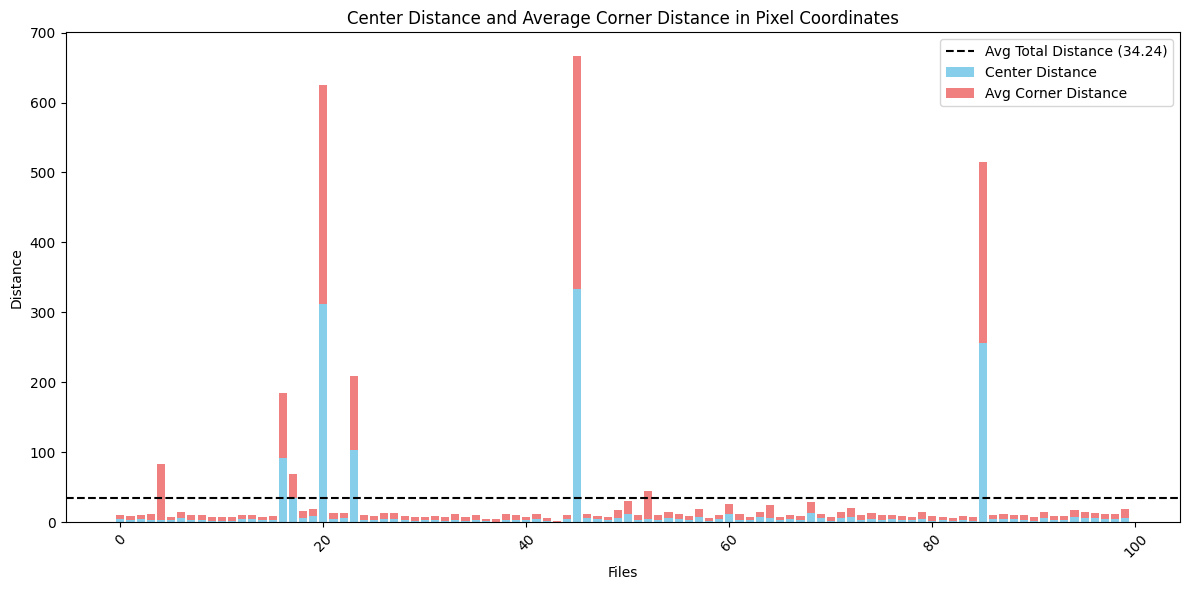

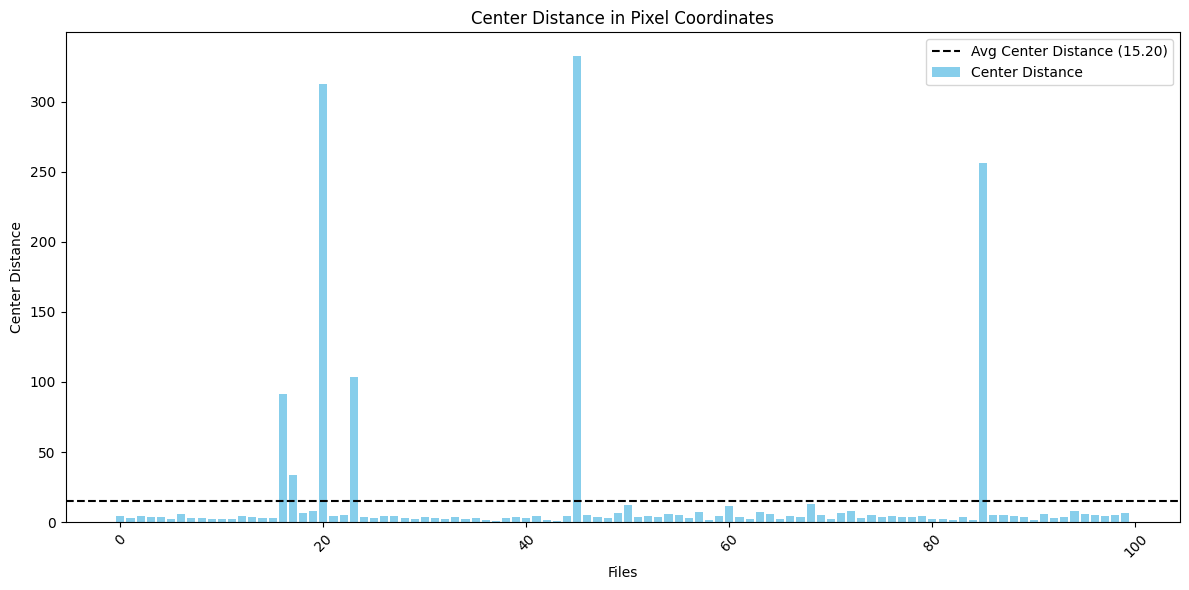

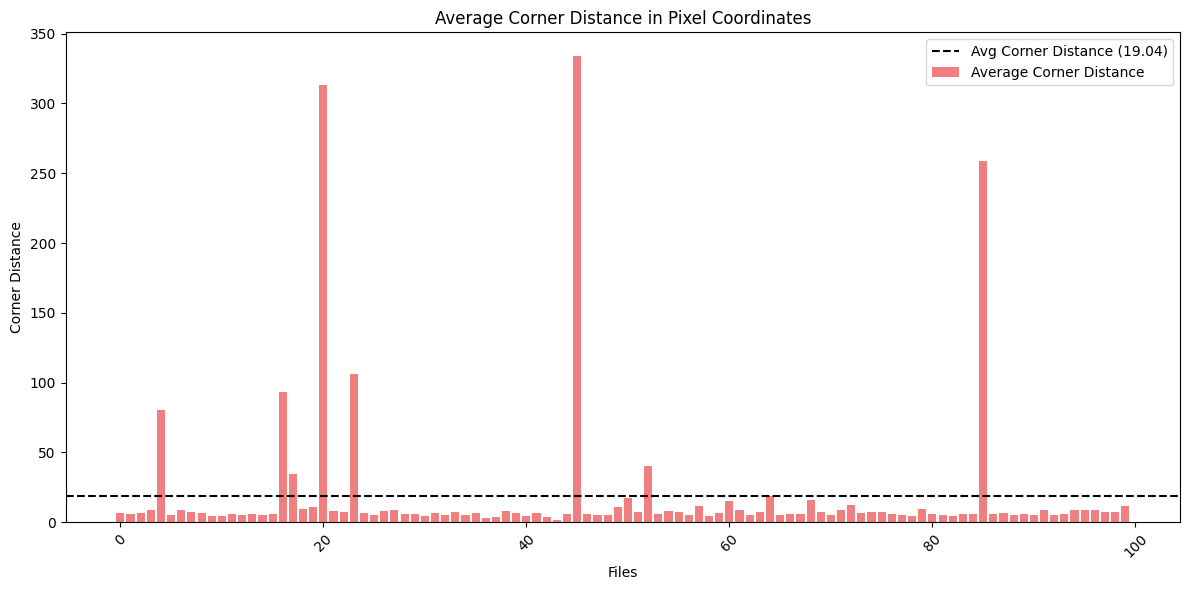

In [139]:
import matplotlib.pyplot as plt
import numpy as np


def generate_bar_plots(results):
    """
    Generate bar plots from the processed results.
    Each bar represents one file with center distance and average corner error stacked.
    Additionally, individual plots for center and corner errors are created.
    """
    # Prepare data
    file_names = []
    center_distances = []
    avg_corner_errors = []

    for file_result in results:
        file_names.append(file_result["file"])
        total_center_distance = 0
        total_avg_corner_error = 0
        count = len(file_result["objects"])
        
        # Sum distances across objects
        for obj in file_result["objects"]:
            total_center_distance += obj["center_distance_non_normalized"]
            total_avg_corner_error += obj["avg_corner_error_non_normalized"]

        # Average values per file
        center_distances.append(total_center_distance / count if count > 0 else 0)
        avg_corner_errors.append(total_avg_corner_error / count if count > 0 else 0)

    # Calculate averages for lines
    avg_center = np.mean(center_distances)
    avg_corner = np.mean(avg_corner_errors)
    
    x = np.arange(len(file_names))


    # Stacked Bar Plot: Center Distance and Average Corner Distance
    plt.figure(figsize=(12, 6))
    plt.bar(x, center_distances, label="Center Distance", color="skyblue")
    plt.bar(x, avg_corner_errors, bottom=center_distances, label="Avg Corner Distance", color="lightcoral")
    plt.axhline(avg_center + avg_corner, color="black", linestyle="--", label=f"Avg Total Distance ({avg_center + avg_corner:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Distance")
    plt.title("Center Distance and Average Corner Distance in Pixel Coordinates")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_center_and_corner_distance.png", dpi=300)
    plt.show()

    # Individual Plot: Center Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, center_distances, color="skyblue", label="Center Distance")
    plt.axhline(avg_center, color="black", linestyle="--", label=f"Avg Center Distance ({avg_center:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Center Distance")
    plt.title("Center Distance in Pixel Coordinates")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_center_distance.png", dpi=300)
    plt.show()

    # Individual Plot: Average Corner Distance with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, avg_corner_errors, color="lightcoral", label="Average Corner Distance")
    plt.axhline(avg_corner, color="black", linestyle="--", label=f"Avg Corner Distance ({avg_corner:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Corner Distance")
    plt.title("Average Corner Distance in Pixel Coordinates")
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_corner_distance.png", dpi=300)
    plt.show()


# Generate the plots
generate_bar_plots(results)


Processing center_distance_normalized


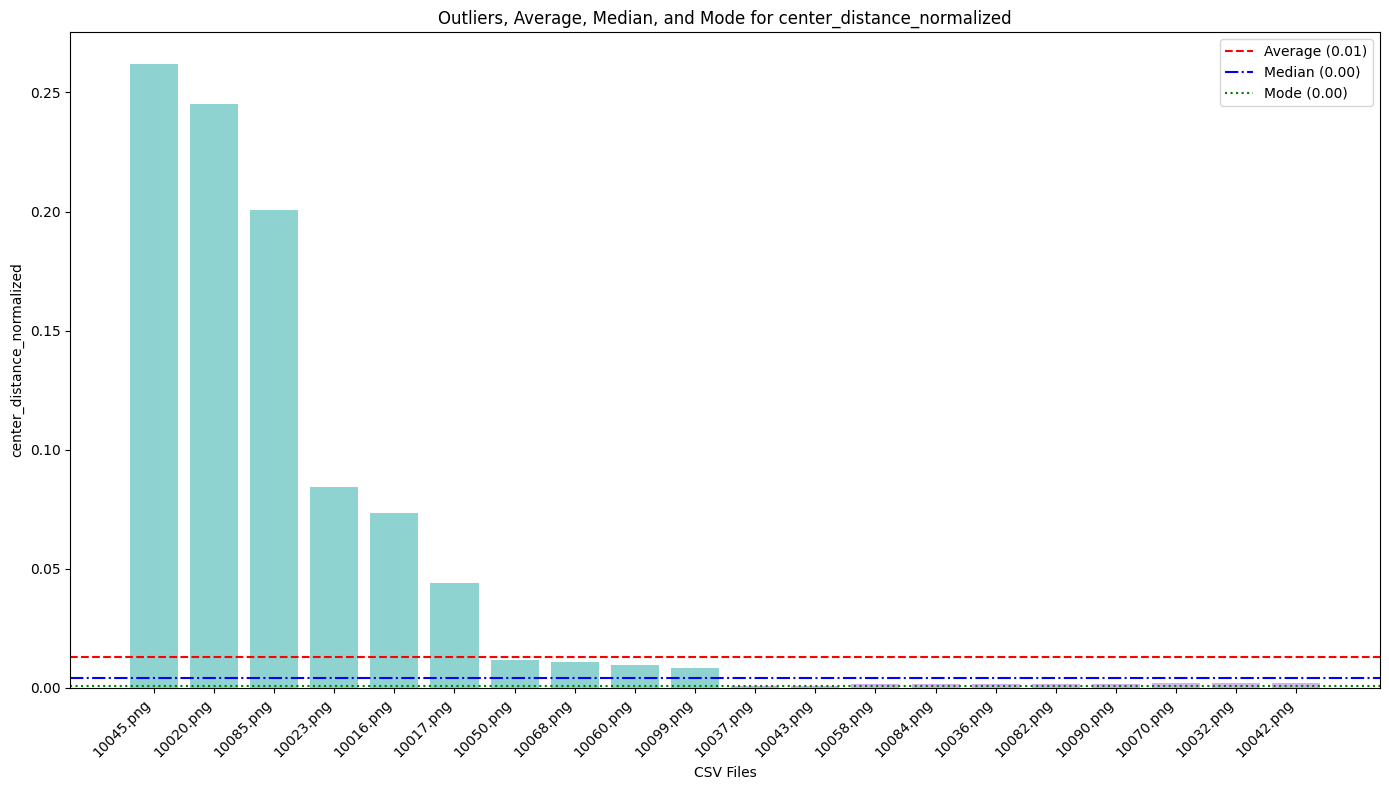

Processing size_distance_normalized


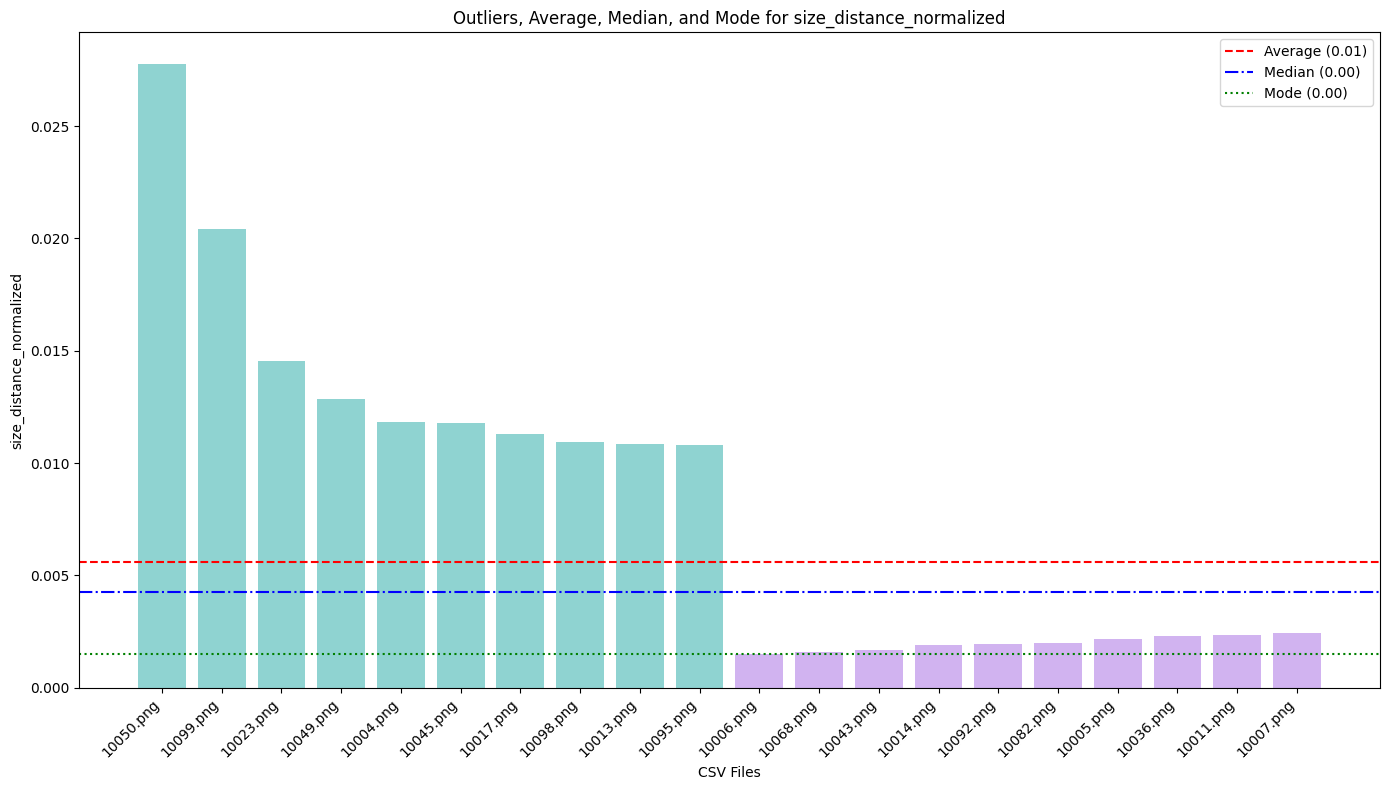

Processing avg_corner_error_normalized


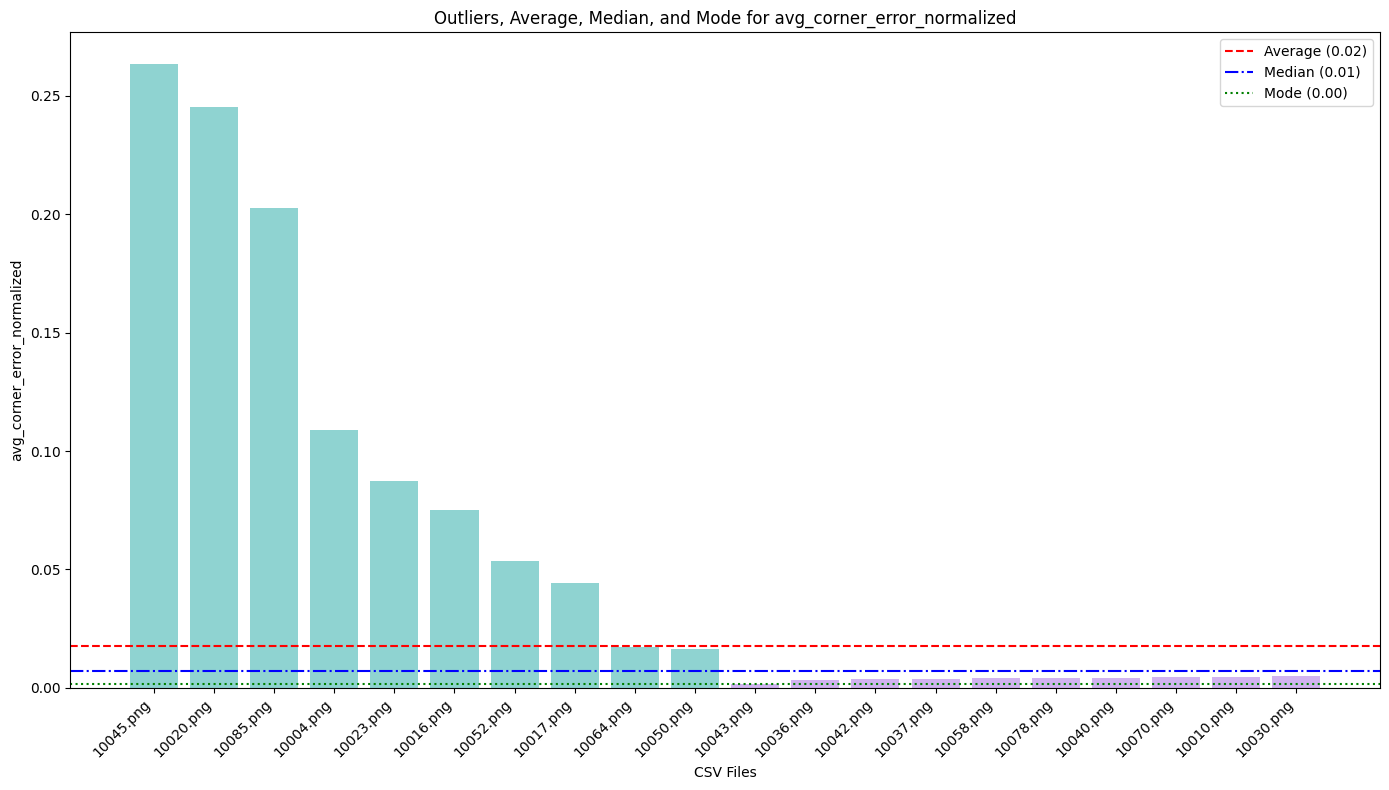

Processing center_distance_non_normalized


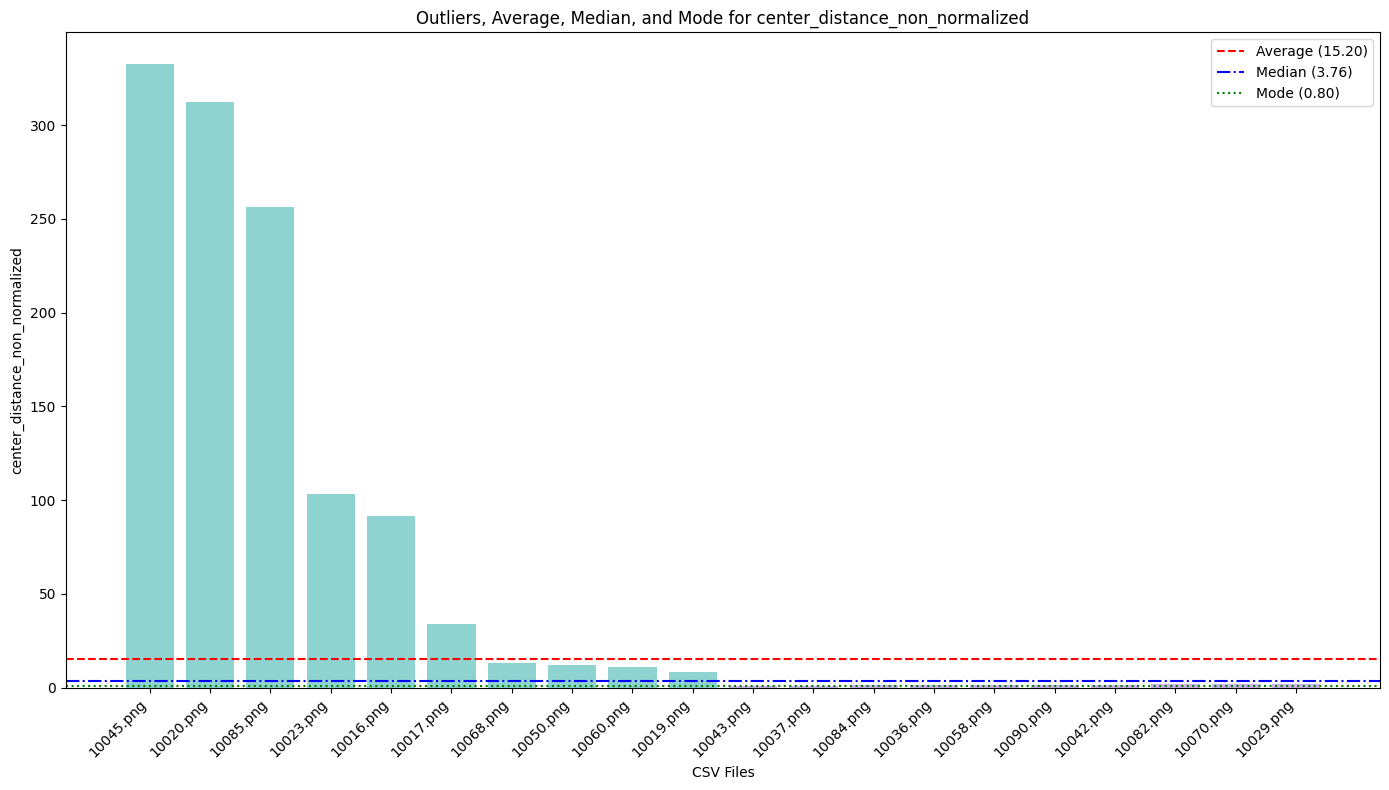

Processing size_distance_non_normalized


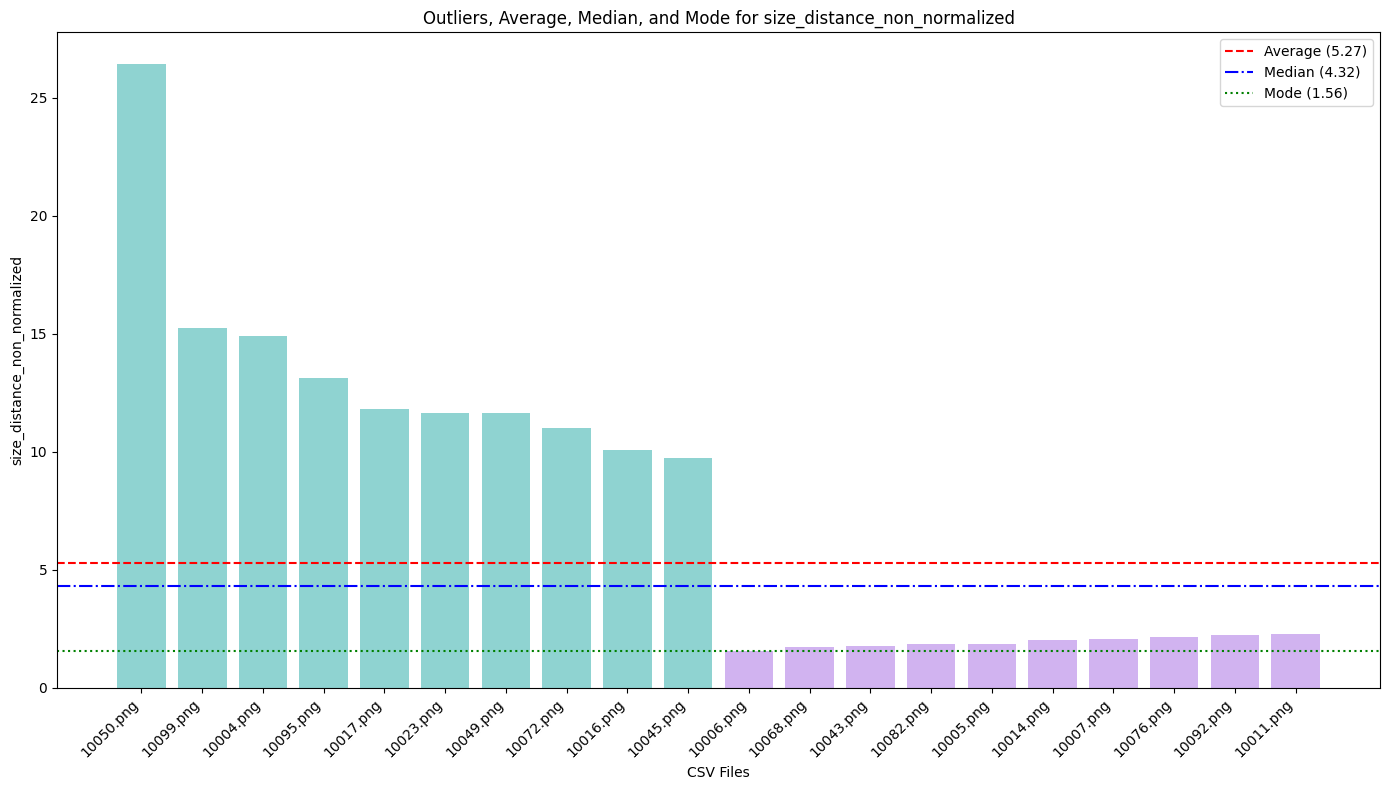

Processing avg_corner_error_non_normalized


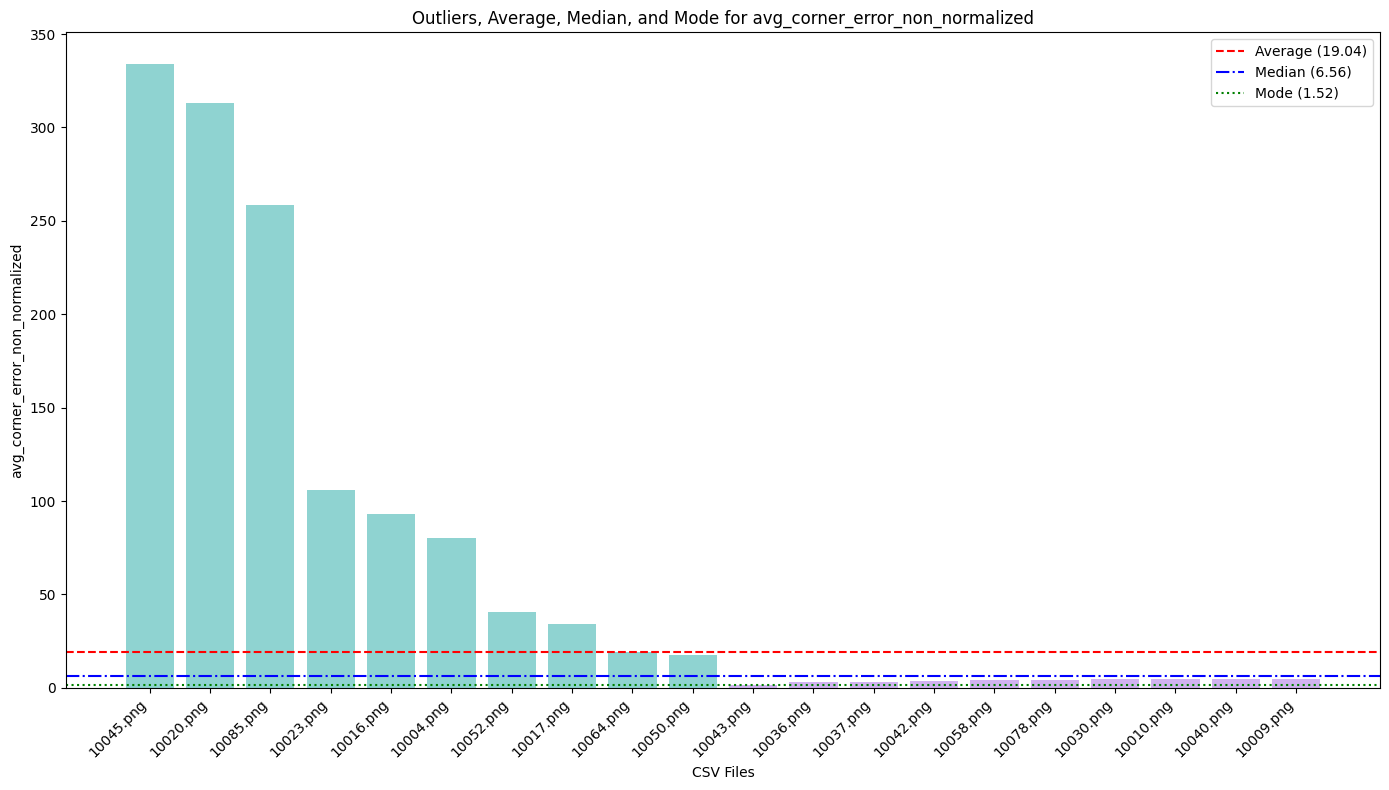

In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert results to a DataFrame for analysis
def process_data(results, metric):
    data = []
    for file_result in results:
        file_name = file_result["file"]
        avg_metric_value = np.mean([
            obj.get(metric, 0) for obj in file_result["objects"]
        ]) if file_result["objects"] else 0
        data.append({"File": file_name, metric: avg_metric_value})
    return pd.DataFrame(data)

# Function to identify outliers, average, median, and mode
def identify_statistics_euc(df, metric):
    top_10_highest = df.nlargest(10, metric)
    top_10_lowest = df.nsmallest(10, metric)
    median_value = df[metric].median()
    avg_value = df[metric].mean()
    mode_value = df[metric].mode().iloc[0] if not df[metric].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualization for metrics
def visualize_statistics_euc(top_10_high, top_10_low, metric, avg_value, median_value, mode_value):
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[metric]

    colors = (
        ['#8fd3d1'] * len(top_10_high) +  # Light teal for highest
        ['#d1b3f0'] * len(top_10_low)    # Light purple for lowest
    )

    plt.figure(figsize=(14, 8))
    bars = plt.bar(labels, values, color=colors)

    # Plot average, median, and mode
    plt.axhline(avg_value, color='red', linestyle='--', linewidth=1.5, label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', linewidth=1.5, label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', linewidth=1.5, label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel(metric)
    plt.title(f"Outliers, Average, Median, and Mode for {metric}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{metric.lower()}_statistics.png", dpi=300)
    plt.legend()
    plt.show()

# Process and visualize each metric
metrics = [
    "center_distance_normalized", 
    "size_distance_normalized", 
    "avg_corner_error_normalized", 
    "center_distance_non_normalized", 
    "size_distance_non_normalized", 
    "avg_corner_error_non_normalized"
]

for metric in metrics:
    print(f"Processing {metric}")
    df = process_data(results, metric)
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_euc(df, metric)
    visualize_statistics_euc(top_10_high, top_10_low, metric, avg_value, median_value, mode_value)


# False Detections and Not Detected

In [141]:
def calculate_fp_and_nd(predictions, ground_truth):
    """
    Calculate False Positives (FP) and Not Detected (ND).
    """
    # If either DataFrame is empty, handle gracefully
    if predictions.empty and ground_truth.empty:
        return 0, 0
    elif predictions.empty:
        return 0, len(ground_truth)
    elif ground_truth.empty:
        return len(predictions), 0

    # Ensure the required column exists
    if 0 not in predictions.columns or 0 not in ground_truth.columns:
        print("Error: Column 0 (Object ID) is missing in one of the DataFrames.")
        return 0, 0

    # Group ground truth and predictions by object ID
    gt_groups = ground_truth.groupby(0)
    pred_groups = predictions.groupby(0)

    # Unique IDs in predictions and ground truth
    gt_ids = set(gt_groups.groups.keys())
    pred_ids = set(pred_groups.groups.keys())

    # Initialize counters for FP and ND
    false_positives = 0
    not_detected = 0

    # IDs only in ground truth (ND)
    unique_gt_ids = gt_ids - pred_ids
    not_detected += sum(len(gt_groups.get_group(id)) for id in unique_gt_ids)

    # IDs only in predictions (FP)
    unique_pred_ids = pred_ids - gt_ids
    false_positives += sum(len(pred_groups.get_group(id)) for id in unique_pred_ids)

    # IDs present in both
    common_ids = gt_ids & pred_ids
    for obj_id in common_ids:
        gt_count = len(gt_groups.get_group(obj_id))
        pred_count = len(pred_groups.get_group(obj_id))

        # Count mismatched instances
        if pred_count > gt_count:
            false_positives += pred_count - gt_count
        elif gt_count > pred_count:
            not_detected += gt_count - pred_count

    return false_positives, not_detected


def process_file_fp_nd(model, image_path, gt_file):
    """
    Process a single file and calculate False Positives (FP) and Not Detected (ND).
    """
    # Perform YOLO inference
    results = model(image_path)[0]

    # Get image dimensions
    img = Image.open(image_path)
    width, height = img.size

    # Prepare prediction data
    predictions = []
    for result in results:
        # Object ID
        obj_id = int(result.boxes.cls[0])  # Class ID

        # Bounding box center and size
        box = result.boxes.xyxy[0].tolist()
        center_x = (box[0] + box[2]) / 2 / width
        center_y = (box[1] + box[3]) / 2 / height
        size_x = (box[2] - box[0]) / width
        size_y = (box[3] - box[1]) / height

        # Keypoints (if available)
        keypoints = []
        if result.keypoints is not None:
            keypoints = result.keypoints.xy[0].tolist()
            keypoints = [(kp[0] / width, kp[1] / height) for kp in keypoints[:8]]

        # Prepare prediction row
        row = [obj_id, center_x, center_y, size_x, size_y]
        row.extend(sum(keypoints, ()))
        predictions.append(row)

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)

    # Load ground truth
    ground_truth = pd.read_csv(gt_file, header=None)

    # Handle empty DataFrames gracefully
    if predictions_df.empty or ground_truth.empty:
        print(f"Skipping file {os.path.basename(image_path)} due to empty DataFrames.")
        return {
            "file": os.path.basename(image_path),
            "false_positives": len(predictions_df),
            "not_detected": len(ground_truth)
        }

    # Calculate FP and ND
    false_positives, not_detected = calculate_fp_and_nd(predictions_df, ground_truth)

    return {
        "file": os.path.basename(image_path),
        "false_positives": false_positives,
        "not_detected": not_detected,
    }


def process_all_files_fp_nd(model_path, image_dir, ground_truth_dir, max_files=None):
    """
    Process all files to calculate False Positives (FP) and Not Detected (ND).

    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        # Image file name without extension
        base_name = os.path.splitext(file_name)[0]

        # Paths
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{base_name}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {base_name}, skipping...")
            continue

        # Process a single file
        try:
            file_results = process_file_fp_nd(model, image_path, gt_file)
            results.append({
                "file": file_results["file"],
                "false_positives": file_results["false_positives"],
                "not_detected": file_results["not_detected"]
            })
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return results



# Calculate FP and ND
results = process_all_files_fp_nd(model_path, image_dir, ground_truth_dir, max_files=100)

print("Results:")
for result in results:
    print(result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 3.0ms postprocess per image 

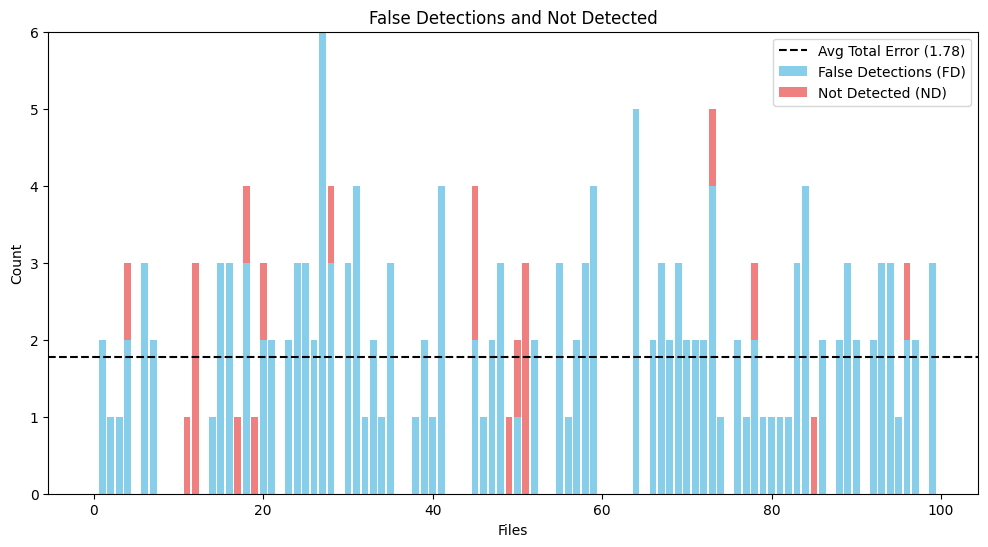

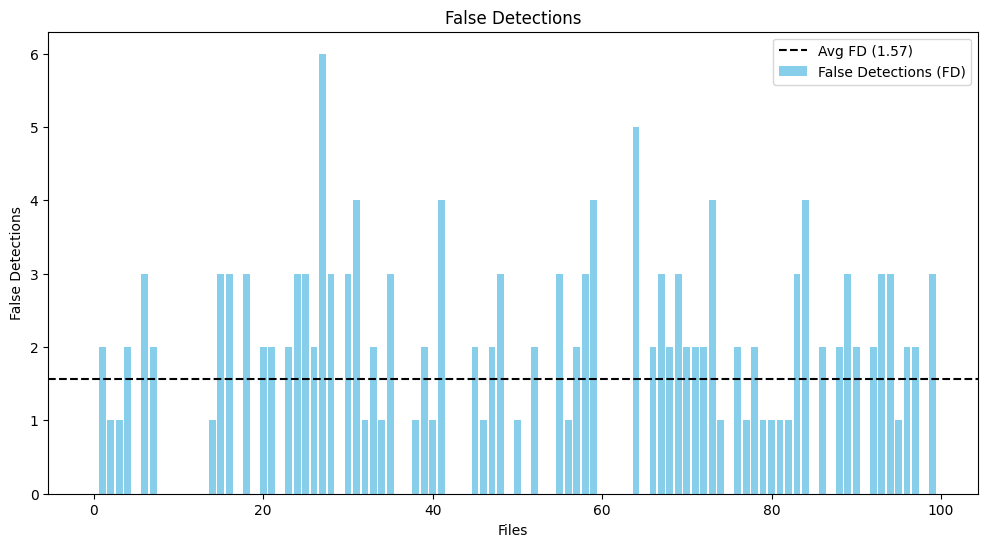

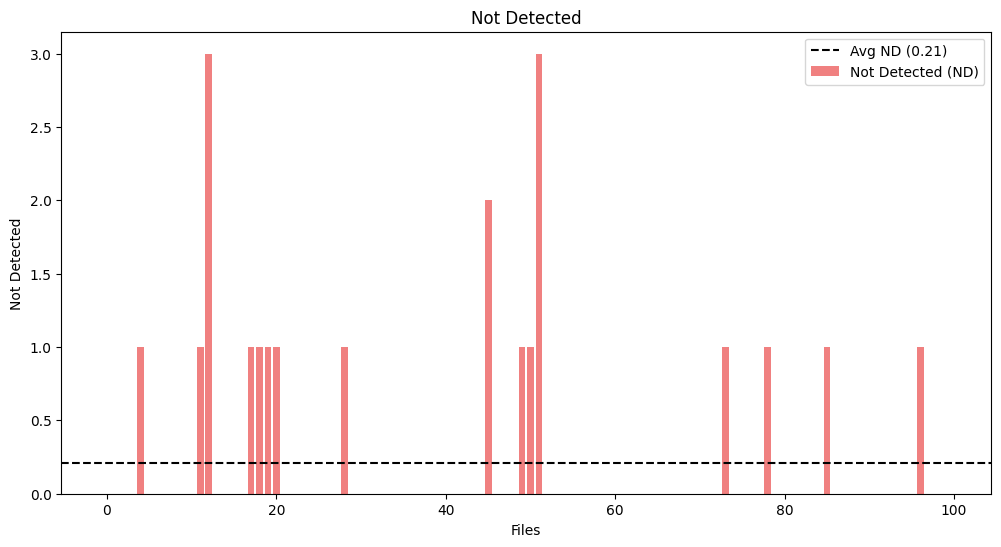

In [142]:
import matplotlib.pyplot as plt
import numpy as np


# Generate bar plots with updated results
def generate_fp_nd_bar_plots(results):
    """
    Generate bar plots for False Positives (FP) and Not Detected (ND).
    Each bar represents one file with FP and ND stacked.
    Also generates individual plots for FP and ND with average lines.
    """
    # Prepare data
    file_names = [result["file"] for result in results]
    false_positives = [result["false_positives"] for result in results]
    not_detected = [result["not_detected"] for result in results]

    # Calculate averages for lines
    avg_fp = np.mean(false_positives)
    avg_nd = np.mean(not_detected)
    
    x = np.arange(len(file_names))

    # Stacked Bar Plot: FP and ND
    plt.figure(figsize=(12, 6))
    plt.bar(x, false_positives, label="False Detections (FD)", color="skyblue")
    plt.bar(x, not_detected, bottom=false_positives, label="Not Detected (ND)", color="lightcoral")
    plt.axhline(avg_fp + avg_nd, color="black", linestyle="--", label=f"Avg Total Error ({avg_fp + avg_nd:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Count")
    plt.title("False Detections and Not Detected")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_false_detections_and_not_detected.png", dpi=300)
    plt.show()

    # Individual Plot: False Positives with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, false_positives, color="skyblue", label="False Detections (FD)")
    plt.axhline(avg_fp, color="black", linestyle="--", label=f"Avg FD ({avg_fp:.2f})")
    plt.xlabel("Files")
    plt.ylabel("False Detections")
    plt.title("False Detections")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_false_detections.png", dpi=300)
    plt.show()

    # Individual Plot: Not Detected with Average Line
    plt.figure(figsize=(12, 6))
    plt.bar(x, not_detected, color="lightcoral", label="Not Detected (ND)")
    plt.axhline(avg_nd, color="black", linestyle="--", label=f"Avg ND ({avg_nd:.2f})")
    plt.xlabel("Files")
    plt.ylabel("Not Detected")
    plt.title("Not Detected")
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_not_detected.png", dpi=300)
    plt.show()


# Generate the plots
generate_fp_nd_bar_plots(results)


Processing False Positives


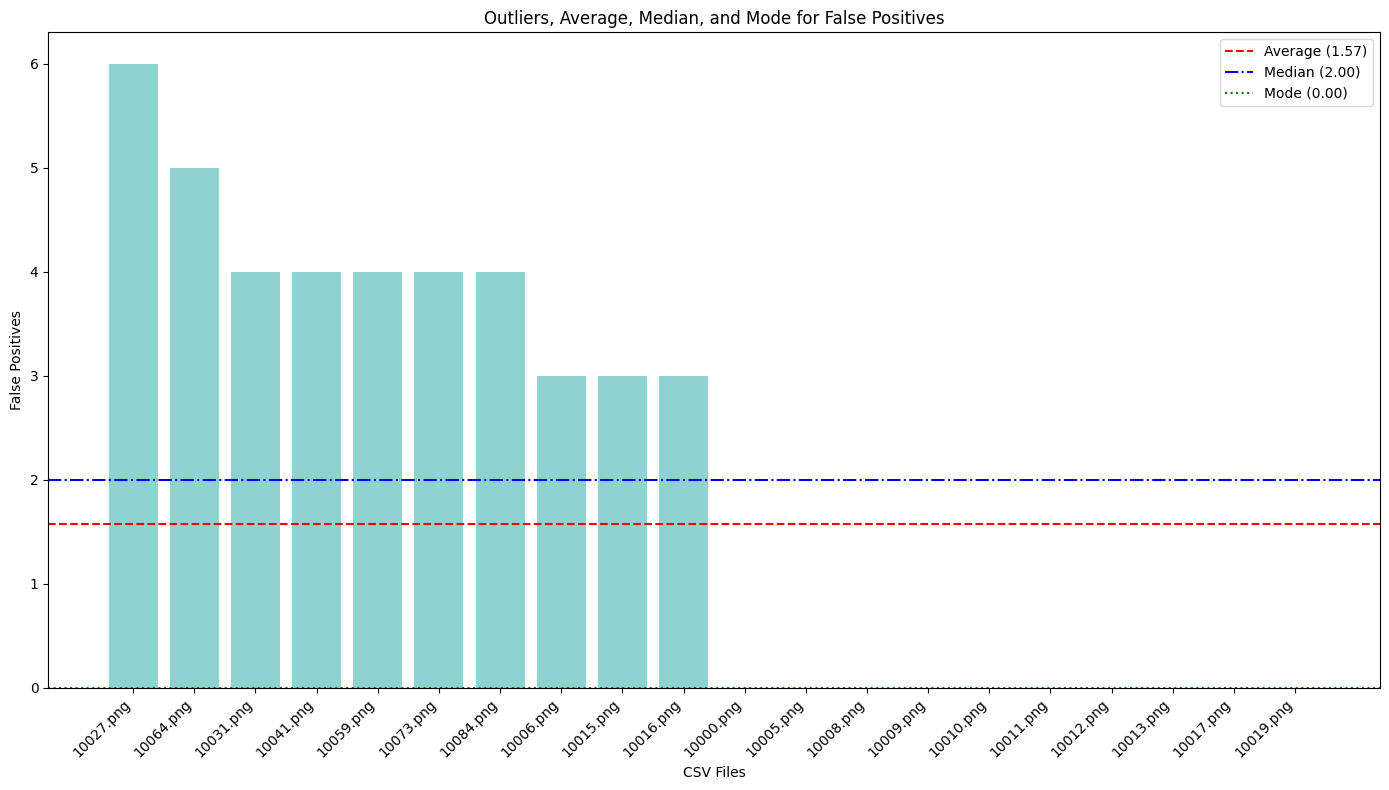

Processing Not Detected


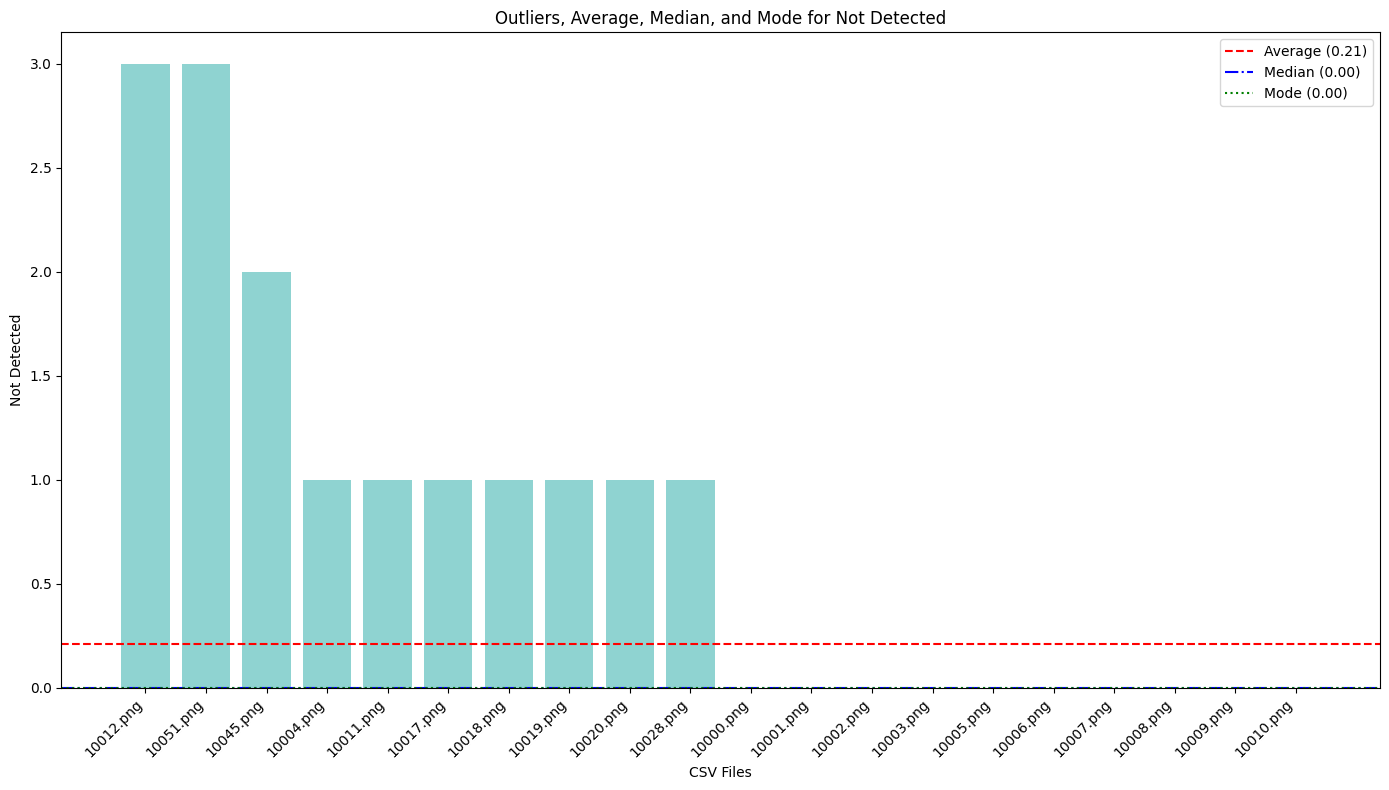

In [143]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert FP and ND results into a DataFrame
def process_fp_nd_results_to_dataframe(results):
    """
    Convert FP and ND results into a DataFrame for analysis.
    """
    data = []
    for result in results:
        file_name = result["file"]
        false_positives = result["false_positives"]
        not_detected = result["not_detected"]
        data.append({"File": file_name, "False Positives": false_positives, "Not Detected": not_detected})
    return pd.DataFrame(data)

# Identify statistics for FP and ND
def identify_statistics_fp_nd(df, column):
    """
    Identify statistical measures for False Positives or Not Detected counts.
    """
    top_10_highest = df.nlargest(10, column)
    top_10_lowest = df.nsmallest(10, column)
    median_value = df[column].median()
    avg_value = df[column].mean()
    mode_value = df[column].mode().iloc[0] if not df[column].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value

# Visualize FP or ND statistics
def visualize_fp_nd_statistics(top_10_high, top_10_low, column, avg_value, median_value, mode_value):
    """
    Visualize the top 10 highest and lowest values for False Positives or Not Detected.
    """
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[column]

    colors = (
        ['#8fd3d1'] * len(top_10_high) +  # Light teal for highest
        ['#d1b3f0'] * len(top_10_low)    # Light purple for lowest
    )

    plt.figure(figsize=(14, 8))
    bars = plt.bar(labels, values, color=colors)

    # Plot average, median, and mode
    plt.axhline(avg_value, color='red', linestyle='--', linewidth=1.5, label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', linewidth=1.5, label=f'Median ({median_value:.2f})')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', linewidth=1.5, label=f'Mode ({mode_value:.2f})')

    plt.xlabel("CSV Files")
    plt.ylabel(column)
    plt.title(f"Outliers, Average, Median, and Mode for {column}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend()
    plt.show()

# Process and visualize FP and ND
df_fp_nd = process_fp_nd_results_to_dataframe(results)

for column in ["False Positives", "Not Detected"]:
    print(f"Processing {column}")
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_fp_nd(df_fp_nd, column)
    visualize_fp_nd_statistics(top_10_high, top_10_low, column, avg_value, median_value, mode_value)


# Intersection Area

In [144]:
import os
import pandas as pd
from ultralytics import YOLO
from PIL import Image


def compute_intersection_area_ratio(gt_row, pred_row, width, height):
    """
    Computes the intersection area ratio of two bounding boxes (ground truth and prediction).
    """
    # Ground truth bounding box edges
    gt_center_x = gt_row[1] * width
    gt_center_y = gt_row[2] * height
    gt_bbox_width = gt_row[3] * width
    gt_bbox_height = gt_row[4] * height

    gt_x1 = gt_center_x - (gt_bbox_width / 2)
    gt_y1 = gt_center_y - (gt_bbox_height / 2)
    gt_x2 = gt_center_x + (gt_bbox_width / 2)
    gt_y2 = gt_center_y + (gt_bbox_height / 2)

    # Prediction bounding box edges
    pred_center_x = pred_row[1] * width
    pred_center_y = pred_row[2] * height
    pred_bbox_width = pred_row[3] * width
    pred_bbox_height = pred_row[4] * height

    pred_x1 = pred_center_x - (pred_bbox_width / 2)
    pred_y1 = pred_center_y - (pred_bbox_height / 2)
    pred_x2 = pred_center_x + (pred_bbox_width / 2)
    pred_y2 = pred_center_y + (pred_bbox_height / 2)

    # Calculate the intersection box
    inter_x1 = max(gt_x1, pred_x1)
    inter_y1 = max(gt_y1, pred_y1)
    inter_x2 = min(gt_x2, pred_x2)
    inter_y2 = min(gt_y2, pred_y2)

    # Calculate intersection area
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    intersection_area = inter_width * inter_height

    # Calculate ground truth area
    gt_area = max(0, (gt_x2 - gt_x1) * (gt_y2 - gt_y1))

    # Avoid division by zero
    if gt_area == 0:
        return 0

    # Return the intersection area ratio
    return intersection_area / gt_area



def calculate_intersection_ratios(predictions, ground_truth, width, height):
    """
    Calculate the intersection area ratios for matched predictions and ground truths.
    """
    results = []

    if predictions.empty or ground_truth.empty:
        print("One of the DataFrames is empty, skipping...")
        return results

    try:
        # Group ground truth and predictions by object ID
        gt_groups = ground_truth.groupby(0)
        pred_groups = predictions.groupby(0)

        # Get the intersection of IDs present in both predictions and ground truth
        common_ids = set(gt_groups.groups.keys()) & set(pred_groups.groups.keys())

        for obj_id in common_ids:
            gt_rows = ground_truth.loc[gt_groups.groups[obj_id]].copy()
            pred_rows = predictions.loc[pred_groups.groups[obj_id]].copy()

            # Match predictions and ground truth for this object ID
            while not gt_rows.empty and not pred_rows.empty:
                max_ratio = None
                max_gt_index = None
                max_pred_index = None

                # Find the prediction-ground truth pair with the highest intersection ratio
                for gt_index, gt_row in gt_rows.iterrows():
                    for pred_index, pred_row in pred_rows.iterrows():
                        ratio = compute_intersection_area_ratio(gt_row, pred_row, width, height)
                        if max_ratio is None or ratio > max_ratio:
                            max_ratio = ratio
                            max_gt_index = gt_index
                            max_pred_index = pred_index

                # Save the intersection ratio result
                results.append({
                    "id": obj_id,
                    "intersection_ratio": max_ratio
                })

                # Remove matched rows
                gt_rows.drop(index=max_gt_index, inplace=True)
                pred_rows.drop(index=max_pred_index, inplace=True)
    except Exception as e:
        print(f"Error calculating intersection ratios: {e}")
    return results


def process_file_intersection(model, image_path, gt_file):
    """
    Process a single image and calculate intersection area ratios.
    """
    try:
        # Perform YOLO inference
        results = model(image_path)[0]

        # Get image dimensions
        img = Image.open(image_path)
        width, height = img.size

        # Prepare prediction data
        predictions = []
        for result in results:
            # Object ID
            obj_id = int(result.boxes.cls[0])  # Class ID

            # Bounding box center and size
            box = result.boxes.xyxy[0].tolist()
            center_x = (box[0] + box[2]) / 2 / width
            center_y = (box[1] + box[3]) / 2 / height
            size_x = (box[2] - box[0]) / width
            size_y = (box[3] - box[1]) / height

            # Prepare prediction row
            row = [obj_id, center_x, center_y, size_x, size_y]
            predictions.append(row)

        # Convert predictions to DataFrame
        predictions_df = pd.DataFrame(predictions)

        # Load ground truth
        ground_truth = pd.read_csv(gt_file, header=None)

        # Ensure DataFrames are not empty
        if predictions_df.empty or ground_truth.empty:
            print(f"Empty DataFrame encountered for {os.path.basename(image_path)}, skipping...")
            return {"file": os.path.basename(image_path), "objects": []}

        # Calculate intersection ratios
        results = calculate_intersection_ratios(predictions_df, ground_truth, width, height)

        # Prepare results for the file
        file_results = {"file": os.path.basename(image_path), "objects": results}
        return file_results
    except Exception as e:
        print(f"Error processing file {os.path.basename(image_path)}: {e}")
        return {"file": os.path.basename(image_path), "objects": []}


def process_all_files_intersection(model_path, image_dir, ground_truth_dir, max_files=None):
    """
    Process all images and calculate intersection area ratios.
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Load YOLO model
    model = YOLO(model_path)
    all_results = []

    # List and sort files numerically
    image_files = sorted(
        [file_name for file_name in os.listdir(image_dir) if file_name.endswith(".png")],
        key=extract_numeric
    )

    # Limit the number of files to process if max_files is set
    if max_files is not None:
        image_files = image_files[:max_files]

    for file_name in image_files:
        image_path = os.path.join(image_dir, file_name)
        gt_file = os.path.join(ground_truth_dir, f"{os.path.splitext(file_name)[0]}.csv")

        if not os.path.exists(gt_file):
            print(f"Missing ground truth for {file_name}, skipping...")
            continue

        # Process a single file and collect results
        try:
            file_results = process_file_intersection(model, image_path, gt_file)
            all_results.append(file_results)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return all_results

# Process files and collect results
results = process_all_files_intersection(model_path, image_dir, ground_truth_dir, max_files=100)

print("Intersection Area Ratios:")
for file_result in results:
    print(file_result)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10003.png: 384x640 4 Vertexs, 1 Common Chair, 1 Office Chair, 2 Windows, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image 

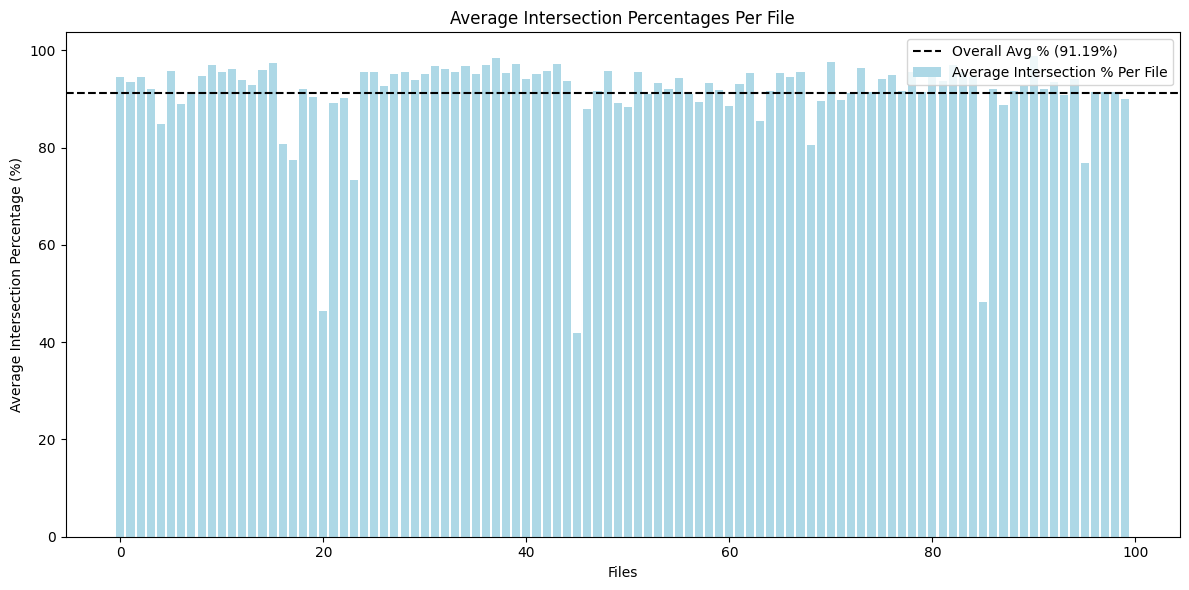

In [145]:
import matplotlib.pyplot as plt
import numpy as np


def generate_average_intersection_plot(results):
    """
    Generate a bar plot showing the average intersection percentage for each file
    and a line for the overall average percentage.
    """
    # Prepare data
    file_names = [result.get("file", "Unknown") for result in results]
    avg_ratios_per_file = [
        100 * np.mean([obj.get("intersection_ratio", 0) for obj in result.get("objects", [])]) if result.get("objects") else 0
        for result in results
    ]
    overall_avg_ratio = np.mean([ratio for ratio in avg_ratios_per_file if ratio > 0])

    x = np.arange(len(file_names))

    # Bar Plot: Average Ratios Per File
    plt.figure(figsize=(12, 6))
    plt.bar(x, avg_ratios_per_file, color="lightblue", label="Average Intersection % Per File")
    plt.axhline(overall_avg_ratio, color="black", linestyle="--", label=f"Overall Avg % ({overall_avg_ratio:.2f}%)")
    plt.xlabel("Files")
    plt.ylabel("Average Intersection Percentage (%)")
    plt.title("Average Intersection Percentages Per File")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(f"{save_dir}\\yolo_{dataset}_average_intersection_percentage.png", dpi=300)
    plt.show()

# Generate the plot
generate_average_intersection_plot(results)


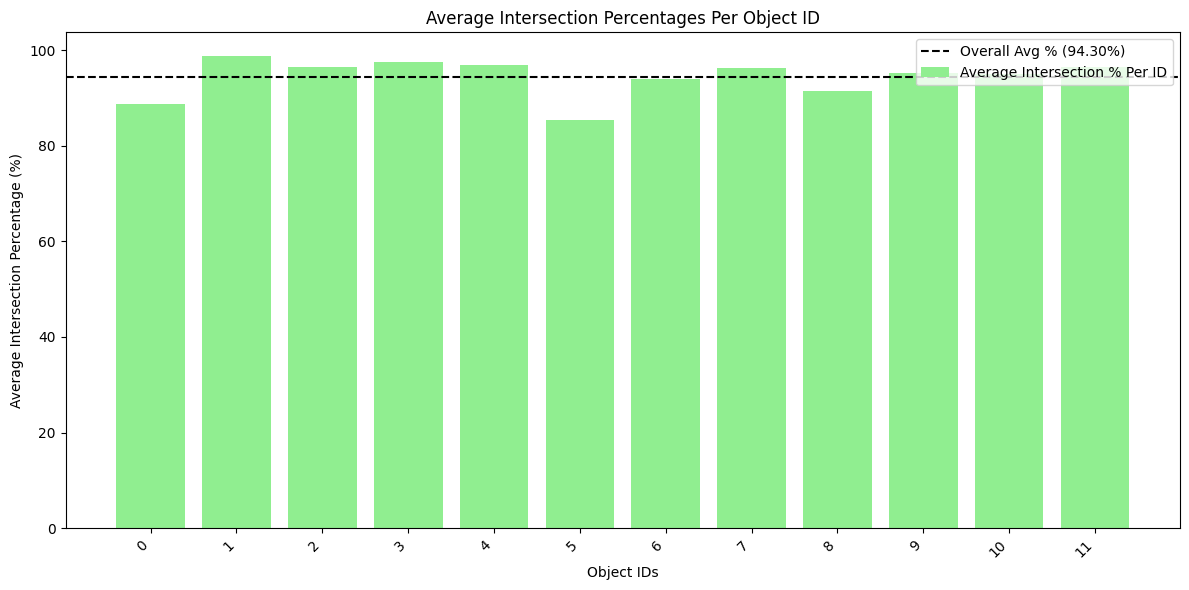

In [146]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


def generate_intersection_plot_per_id(results):
    """
    Generate bar plots showing the average intersection percentage for each object ID across files.
    """
    # Collect data per ID
    id_data = defaultdict(list)  # {id: [ratios]}
    for result in results:
        for obj in result.get("objects", []):
            obj_id = obj.get("id")
            intersection_ratio = 100 * obj.get("intersection_ratio", 0)  # Convert to percentage
            id_data[obj_id].append(intersection_ratio)

    # Calculate average ratios per ID
    avg_ratios_per_id = {obj_id: np.mean(ratios) for obj_id, ratios in id_data.items() if ratios}

    # Sort IDs for consistent plotting
    sorted_ids = sorted(avg_ratios_per_id.keys())

    # Prepare data for plotting
    avg_ratios = [avg_ratios_per_id[obj_id] for obj_id in sorted_ids]

    x = np.arange(len(sorted_ids))

    # Bar Plot: Average Intersection Ratios Per ID
    plt.figure(figsize=(12, 6))
    plt.bar(x, avg_ratios, color="lightgreen", label="Average Intersection % Per ID")
    overall_avg_ratio = np.mean(avg_ratios)
    plt.axhline(overall_avg_ratio, color="black", linestyle="--", label=f"Overall Avg % ({overall_avg_ratio:.2f}%)")
    plt.xticks(x, sorted_ids, rotation=45, ha="right")
    plt.xlabel("Object IDs")
    plt.ylabel("Average Intersection Percentage (%)")
    plt.title("Average Intersection Percentages Per Object ID")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Generate the plot for IDs
generate_intersection_plot_per_id(results)


Processing Intersection Ratios


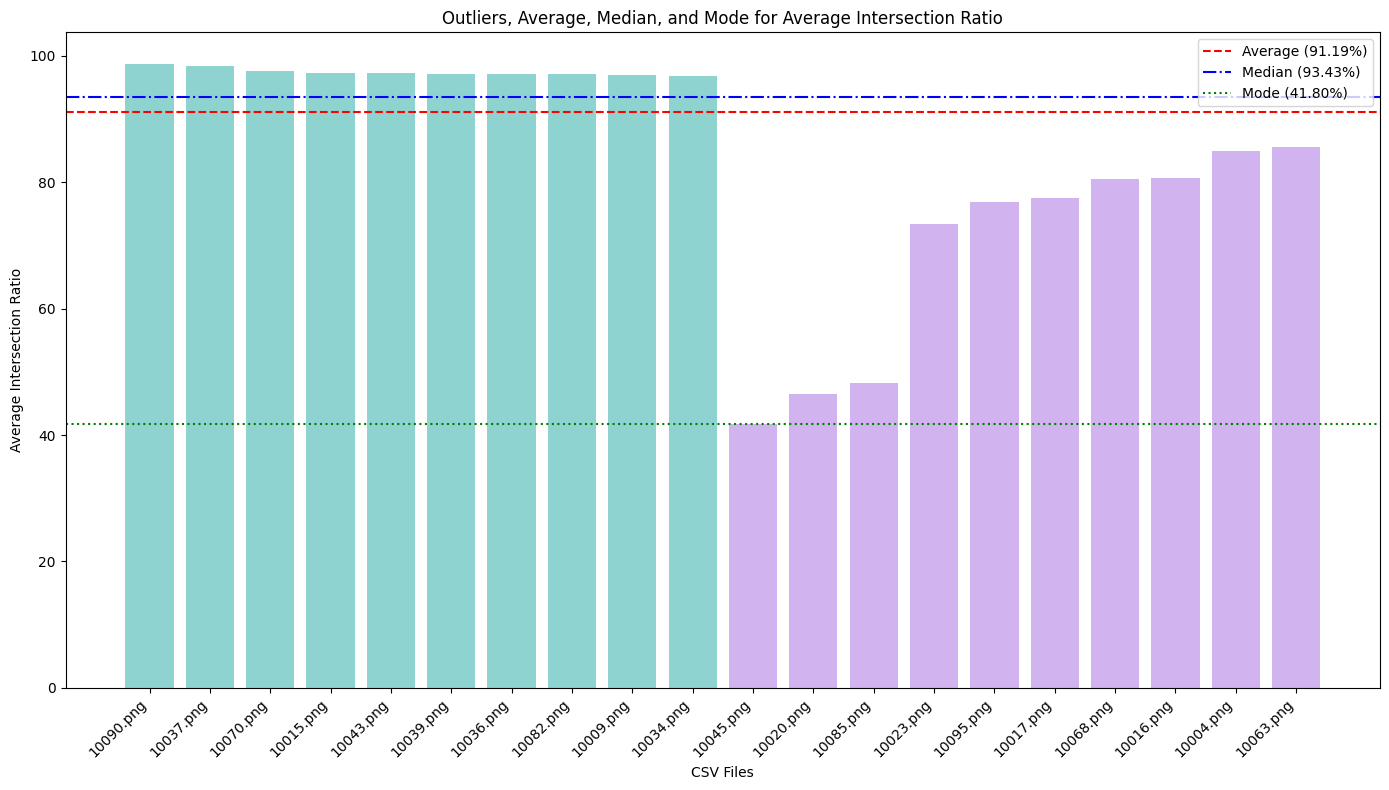

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def process_intersection_results_to_dataframe(results):
    """
    Convert intersection area ratio results into a DataFrame for analysis.
    """
    data = []
    for file_result in results:
        file_name = file_result.get("file", "Unknown")
        avg_intersection_ratio = (
            100 * np.mean([obj.get("intersection_ratio", 0) for obj in file_result.get("objects", [])])
            if file_result.get("objects") else 0
        )
        data.append({"File": file_name, "Average Intersection Ratio": avg_intersection_ratio})
    return pd.DataFrame(data)


def identify_statistics_intersection(df, column):
    """
    Identify statistical measures for intersection ratios.
    """
    top_10_highest = df.nlargest(10, column)
    top_10_lowest = df.nsmallest(10, column)
    median_value = df[column].median()
    avg_value = df[column].mean()
    mode_value = df[column].mode().iloc[0] if not df[column].mode().empty else None
    return top_10_highest, top_10_lowest, avg_value, median_value, mode_value


def visualize_intersection_statistics(top_10_high, top_10_low, column, avg_value, median_value, mode_value):
    """
    Visualize the top 10 highest and lowest values for intersection ratios.
    """
    combined = pd.concat([top_10_high, top_10_low])
    labels = combined["File"]
    values = combined[column]

    colors = (
        ['#8fd3d1'] * len(top_10_high) +  # Light teal for highest
        ['#d1b3f0'] * len(top_10_low)    # Light purple for lowest
    )

    plt.figure(figsize=(14, 8))
    bars = plt.bar(labels, values, color=colors)

    # Plot average, median, and mode
    plt.axhline(avg_value, color='red', linestyle='--', linewidth=1.5, label=f'Average ({avg_value:.2f}%)')
    plt.axhline(median_value, color='blue', linestyle='-.', linewidth=1.5, label=f'Median ({median_value:.2f}%)')
    if mode_value is not None:
        plt.axhline(mode_value, color='green', linestyle=':', linewidth=1.5, label=f'Mode ({mode_value:.2f}%)')

    plt.xlabel("CSV Files")
    plt.ylabel(column)
    plt.title(f"Outliers, Average, Median, and Mode for {column}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.legend()
    plt.show()


# Process and visualize intersection statistics
try:
    df_intersection = process_intersection_results_to_dataframe(results)
    print("Processing Intersection Ratios")
    top_10_high, top_10_low, avg_value, median_value, mode_value = identify_statistics_intersection(df_intersection, "Average Intersection Ratio")
    visualize_intersection_statistics(top_10_high, top_10_low, "Average Intersection Ratio", avg_value, median_value, mode_value)
except Exception as e:
    print(f"Error processing intersection results: {e}")


In [148]:
import os
import numpy as np
import pandas as pd
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Error calculation functions
def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))

# Load YOLO model
model = YOLO(model_path)

def process_images(image_dir, ground_truth_dir, model, max_files=None):
    """
    Process images and calculate errors between predictions and ground truth.
    """
    def extract_numeric(file_name):
        # Extract the numeric part of the file name (e.g., "123" from "123.png")
        return int(os.path.splitext(file_name)[0])

    # Initialize error storage
    errors = {}

    # List and sort image files numerically
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))],
        key=extract_numeric
    )

    # Limit the number of files if max_files is specified
    if max_files is not None:
        image_files = image_files[:max_files]

    total_files = len(image_files)

    # Loop through all images with progress bar
    for idx, image_file in enumerate(image_files):
        print(f"Processing file {idx + 1}/{total_files} ({((idx + 1) / total_files) * 100:.2f}%) - {image_file}")
        image_path = os.path.join(image_dir, image_file)
        ground_truth_2d_path = os.path.join(ground_truth_dir, image_file.replace(".jpg", ".csv").replace(".png", ".csv"))

        # Check if the corresponding 2D CSV exists
        if not os.path.exists(ground_truth_2d_path):
            print(f"Ground truth 2D data for {image_file} not found. Skipping.")
            continue

        # Perform YOLO inference
        results = model(image_path)[0]
        img = Image.open(image_path)
        width, height = img.size

        # Extract predicted points
        predicted_points = []
        for result in results:
            if result.keypoints is not None:
                keypoints = result.keypoints.xy[0].tolist()
                predicted_points.extend([(kp[0], kp[1]) for kp in keypoints[:8]])  # Use raw predictions

        # Load ground truth 2D points
        try:
            ground_truth_df = pd.read_csv(ground_truth_2d_path, header=None)
            ground_truth_points = ground_truth_df.iloc[0, 1:].values.reshape(-1, 2)  # Drop ID column
            ground_truth_points[:, 0] *= width  # Scale x-coordinates
            ground_truth_points[:, 1] *= height  # Scale y-coordinates
        except Exception as e:
            print(f"Error loading ground truth 2D data for {image_file}: {e}")
            continue

        if len(predicted_points) < 8 or len(ground_truth_points) < 8:
            print(f"Not enough keypoints for {image_file}. Skipping.")
            continue

        predicted_points = np.array(predicted_points[:8])  # Ensure only first 8 points
        ground_truth_points = np.array(ground_truth_points[:8])

        # Split into components
        pred_bb_center = predicted_points[:1, :2]
        gt_bb_center = ground_truth_points[:1, :2]

        pred_bb_size = predicted_points[1:2, :2]
        gt_bb_size = ground_truth_points[1:2, :2]

        pred_corners = predicted_points[2:8, :]
        gt_corners = ground_truth_points[2:8, :]

        # Calculate errors
        rmse_bb_center = calculate_rmse(pred_bb_center, gt_bb_center)
        rmse_bb_size = calculate_rmse(pred_bb_size, gt_bb_size)
        rmse_corners = calculate_rmse(pred_corners, gt_corners)

        mae_bb_center = calculate_mae(pred_bb_center, gt_bb_center)
        mae_bb_size = calculate_mae(pred_bb_size, gt_bb_size)
        mae_corners = calculate_mae(pred_corners, gt_corners)

        total_rmse = rmse_bb_center + rmse_bb_size + rmse_corners
        total_mae = mae_bb_center + mae_bb_size + mae_corners

        errors[image_file] = {
            "RMSE_BB_Center": rmse_bb_center,
            "RMSE_BB_Size": rmse_bb_size,
            "RMSE_Corners": rmse_corners,
            "RMSE_Total": total_rmse,
            "MAE_BB_Center": mae_bb_center,
            "MAE_BB_Size": mae_bb_size,
            "MAE_Corners": mae_corners,
            "MAE_Total": total_mae,
        }

    return errors


max_files_to_process = 100 
errors = process_images(image_dir, ground_truth_dir, model, max_files=max_files_to_process)

# Output errors
print("Processed Errors:")
for file_name, error_data in errors.items():
    print(file_name, error_data)


Processing file 1/100 (1.00%) - 10000.png

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10000.png: 384x640 2 Vertexs, 1 Common Chair, 1 Door, 1 Office Chair, 1 Window, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Processing file 2/100 (2.00%) - 10001.png

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10001.png: 384x640 6 Vertexs, 1 Office Chair, 2 Windows, 17.0ms
Speed: 6.5ms preprocess, 17.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Processing file 3/100 (3.00%) - 10002.png

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\test\10002.png: 384x640 5 Vertexs, 1 Common Chair, 1 Door, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Processing file 4/100 (4.00%) - 10003.png

image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_d

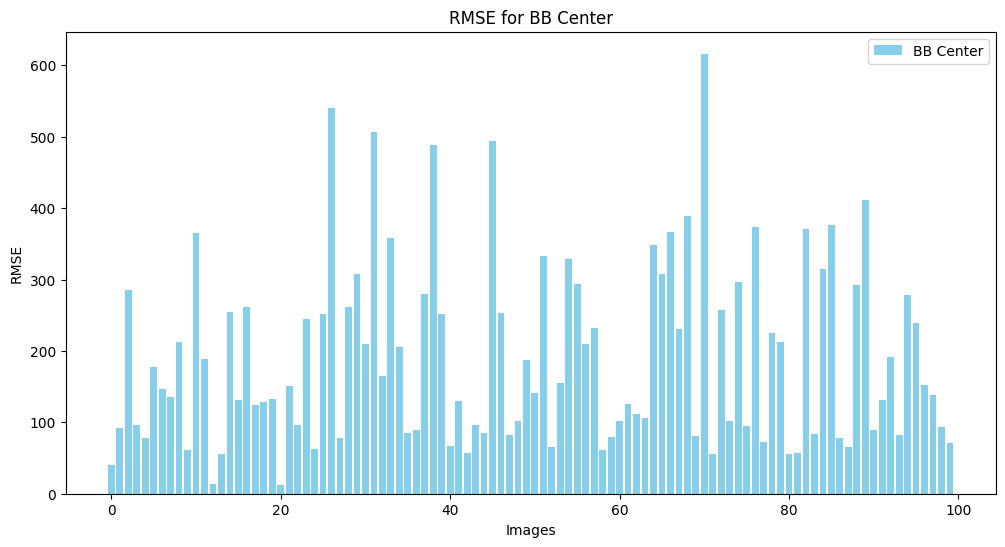

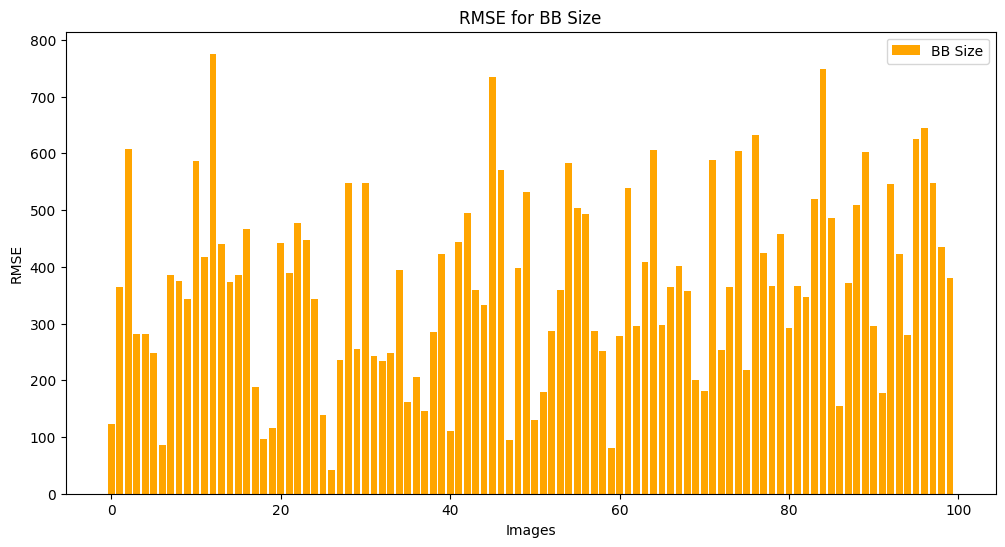

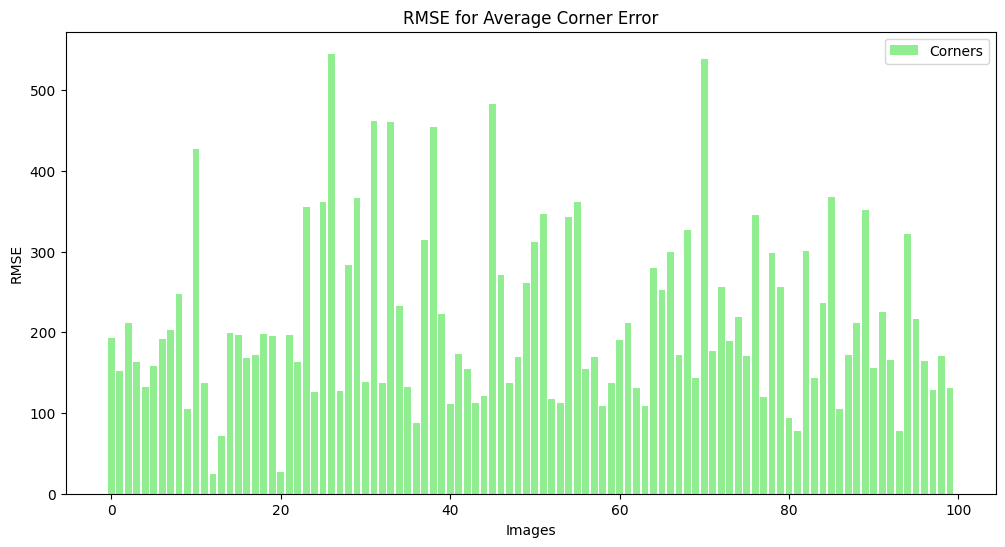

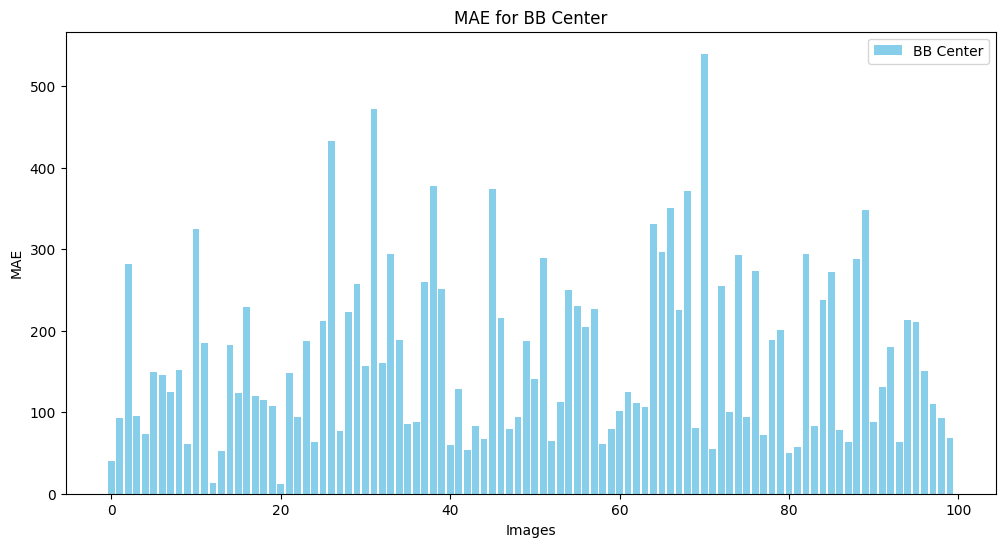

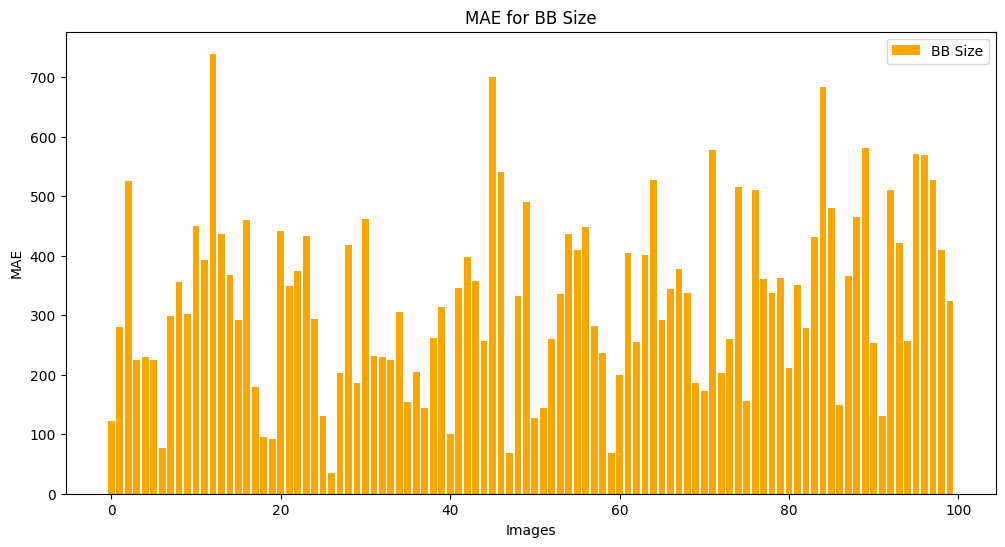

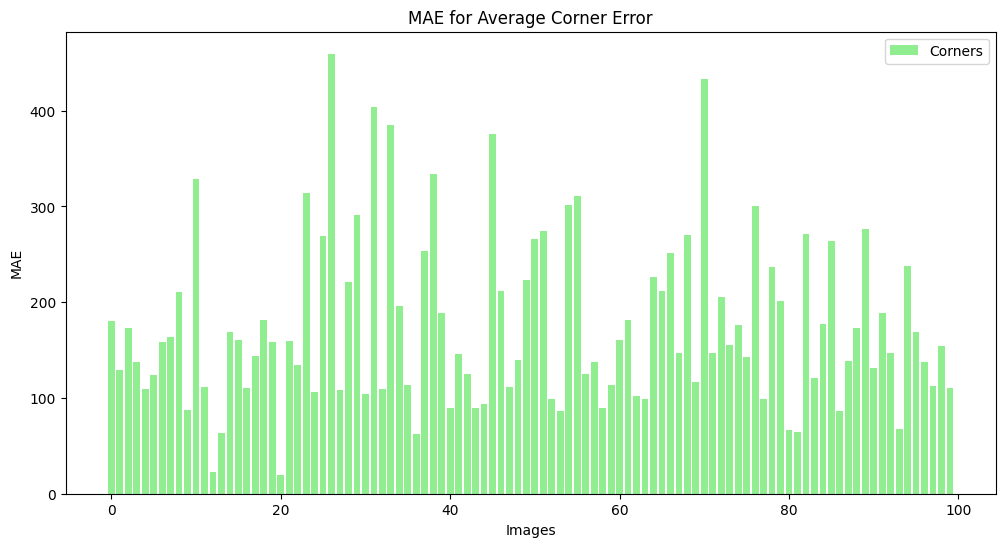

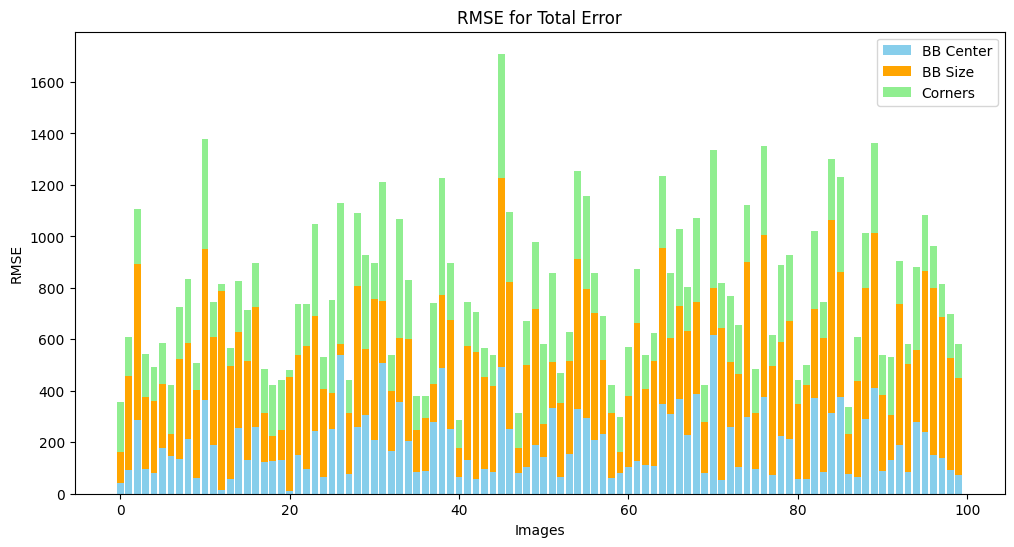

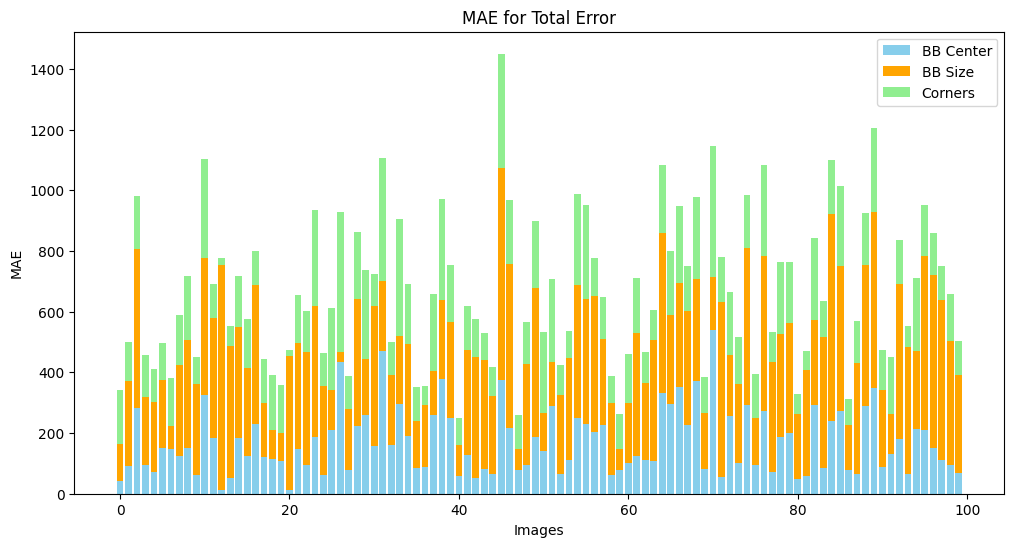

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generic function to create individual bar plots
def plot_bar(df, x, column, ylabel, title, color, label):
    plt.figure(figsize=(12, 6))
    plt.bar(x, df[column], color=color, label=label)
    plt.xlabel("Images")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{column.lower()}.png", dpi=300)
    plt.show()

# Generic function to create stacked bar plots
def plot_stacked(df, x, columns, ylabel, title, colors, labels):
    plt.figure(figsize=(12, 6))
    bottom_values = np.zeros(len(df))
    for col, color, label in zip(columns, colors, labels):
        plt.bar(x, df[col], bottom=bottom_values, color=color, label=label)
        bottom_values += df[col]
    plt.xlabel("Images")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{'_'.join(columns).lower()}.png", dpi=300)
    plt.show()

# Visualization
def visualize_errors(errors):
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    x = np.arange(len(df))

    # Define configurations for individual plots
    bar_configs = [
        {"column": "RMSE_BB_Center", "ylabel": "RMSE", "title": "RMSE for BB Center", "color": "skyblue", "label": "BB Center"},
        {"column": "RMSE_BB_Size", "ylabel": "RMSE", "title": "RMSE for BB Size", "color": "orange", "label": "BB Size"},
        {"column": "RMSE_Corners", "ylabel": "RMSE", "title": "RMSE for Average Corner Error", "color": "lightgreen", "label": "Corners"},
        {"column": "MAE_BB_Center", "ylabel": "MAE", "title": "MAE for BB Center", "color": "skyblue", "label": "BB Center"},
        {"column": "MAE_BB_Size", "ylabel": "MAE", "title": "MAE for BB Size", "color": "orange", "label": "BB Size"},
        {"column": "MAE_Corners", "ylabel": "MAE", "title": "MAE for Average Corner Error", "color": "lightgreen", "label": "Corners"}
    ]

    # Plot individual bar charts
    for config in bar_configs:
        plot_bar(df, x, **config)

    # Plot stacked charts
    stacked_configs = [
        {
            "columns": ["RMSE_BB_Center", "RMSE_BB_Size", "RMSE_Corners"],
            "ylabel": "RMSE",
            "title": "RMSE for Total Error",
            "colors": ["skyblue", "orange", "lightgreen"],
            "labels": ["BB Center", "BB Size", "Corners"],
        },
        {
            "columns": ["MAE_BB_Center", "MAE_BB_Size", "MAE_Corners"],
            "ylabel": "MAE",
            "title": "MAE for Total Error",
            "colors": ["skyblue", "orange", "lightgreen"],
            "labels": ["BB Center", "BB Size", "Corners"],
        }
    ]

    for config in stacked_configs:
        plot_stacked(df, x, **config)

# Call visualization
visualize_errors(errors)


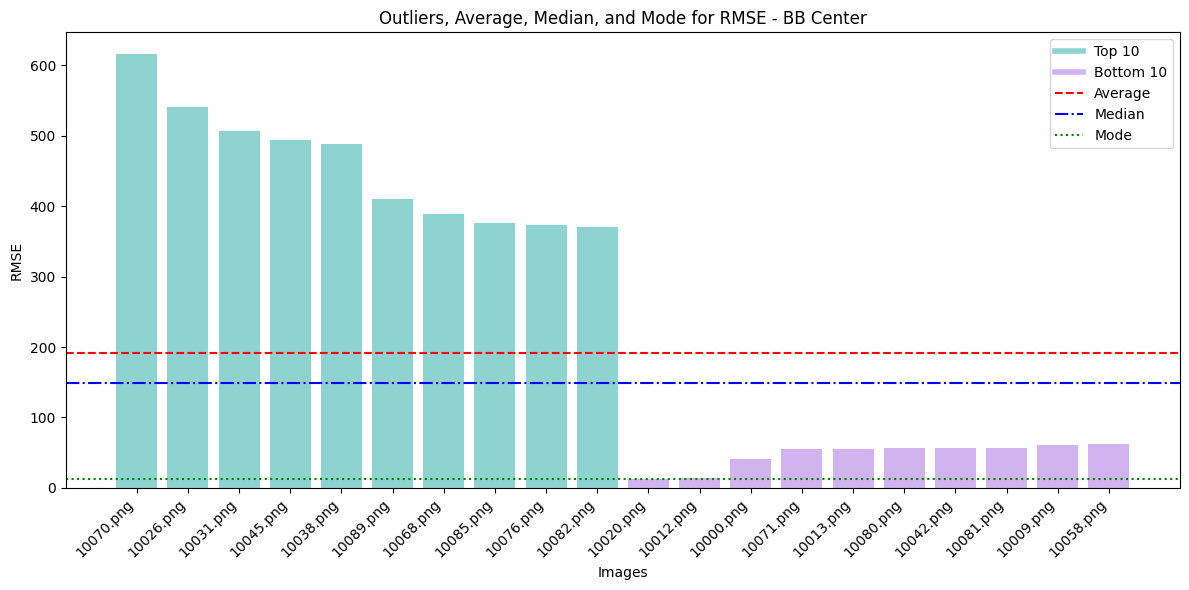

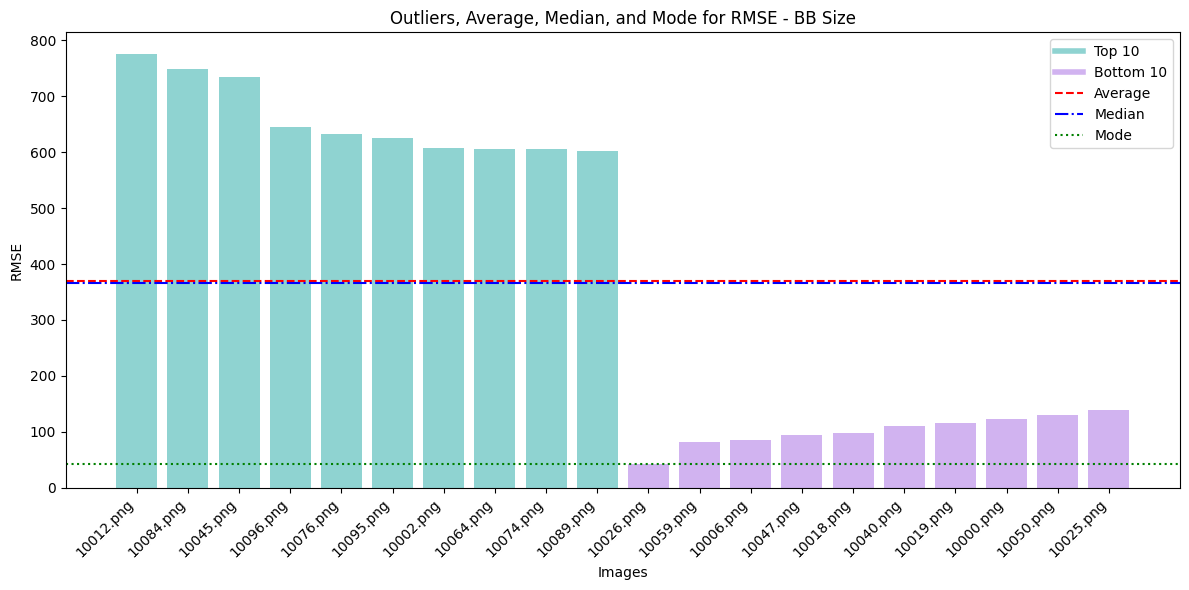

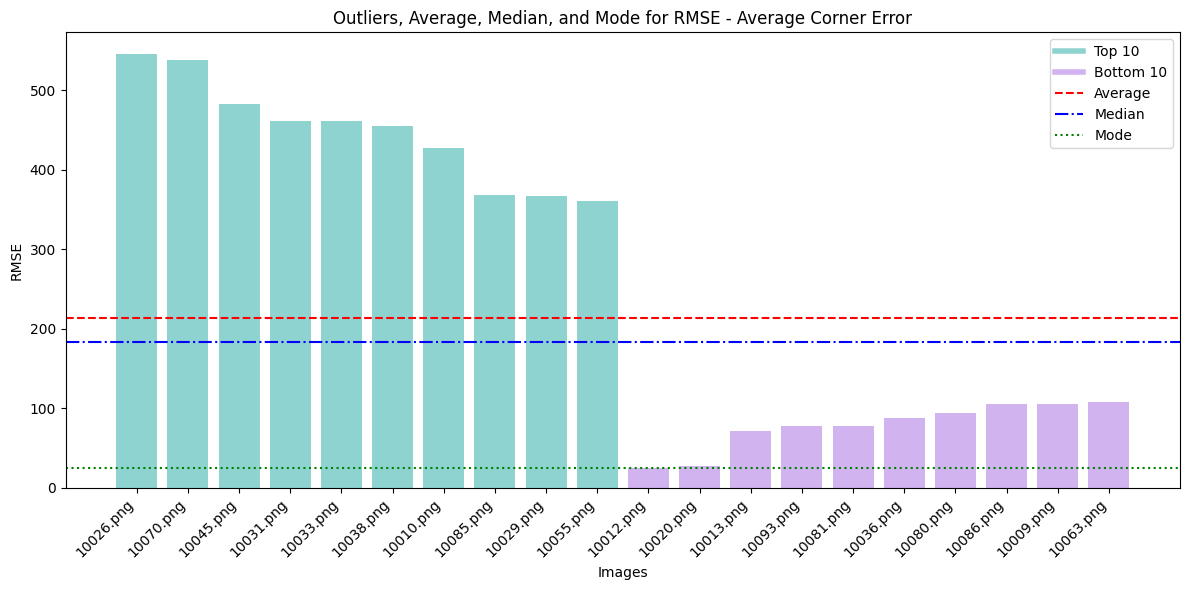

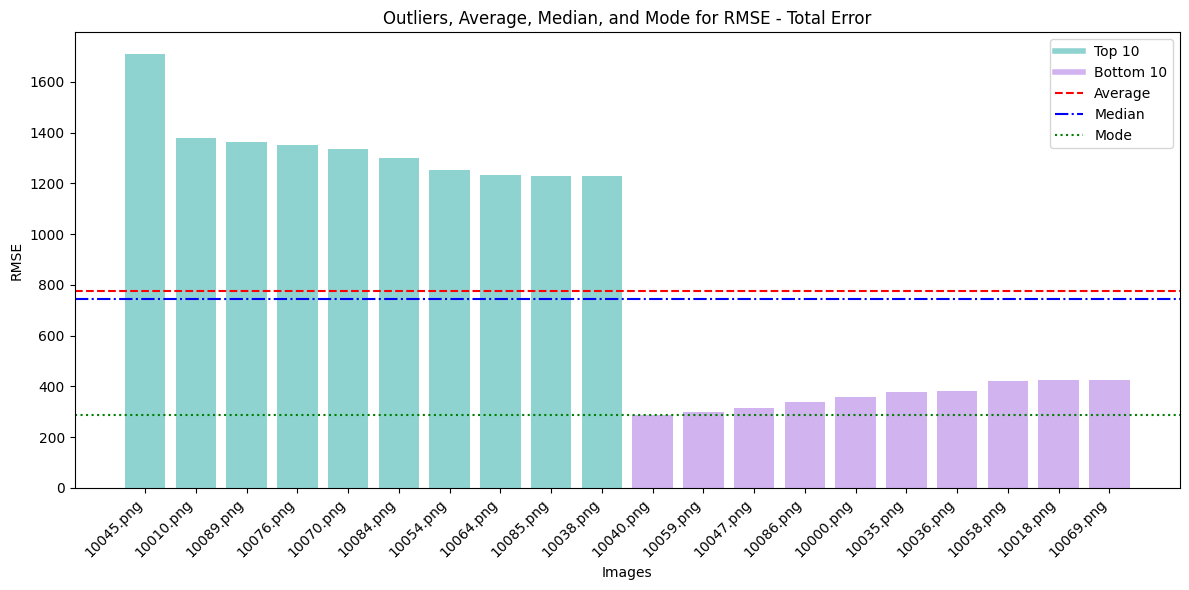

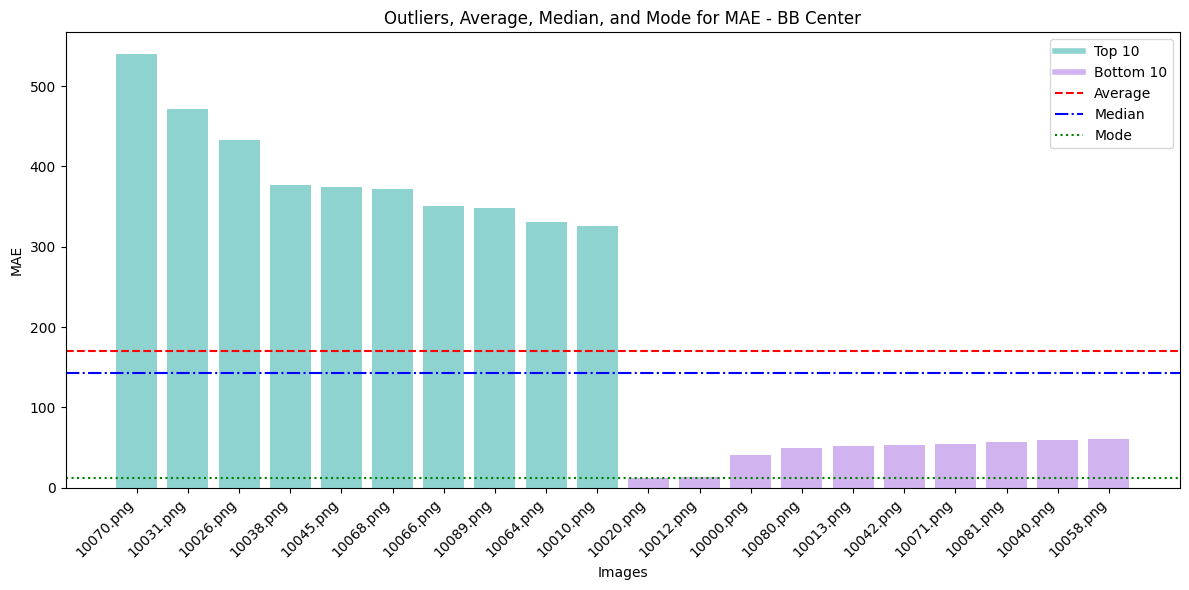

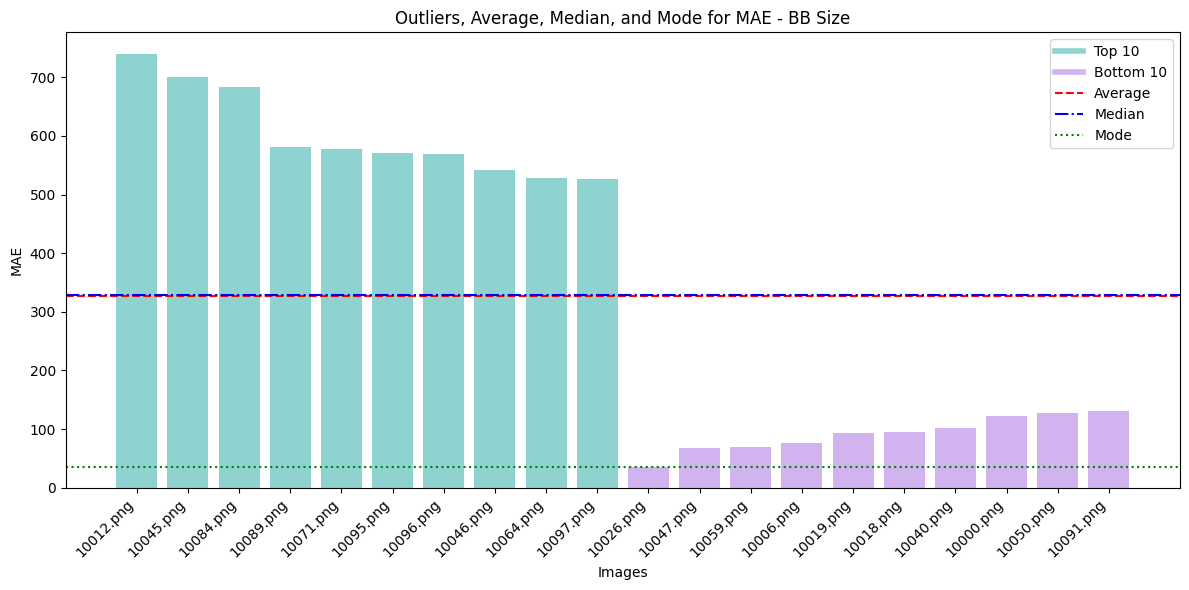

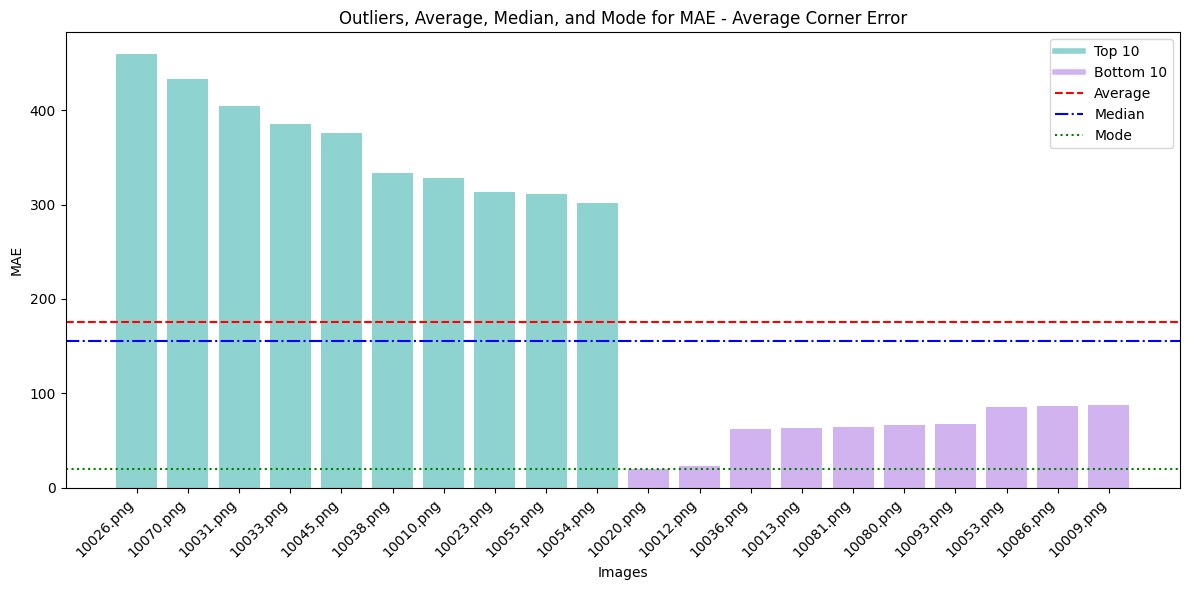

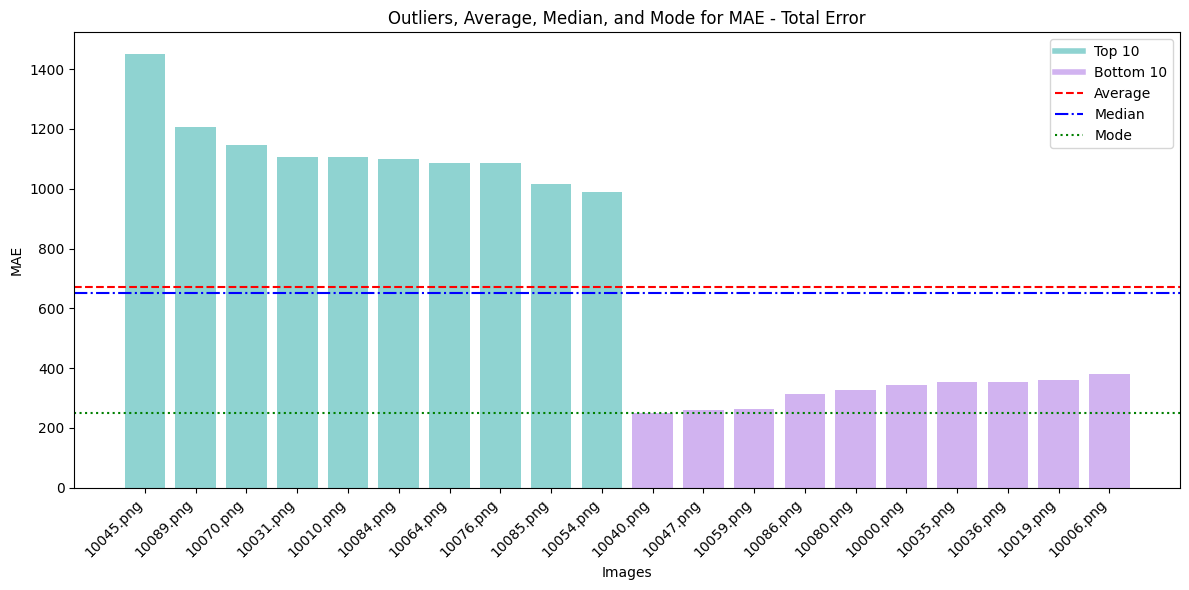

In [150]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to identify top and bottom values, along with statistical measures
def identify_statistics(df, category):
    sorted_df = df.sort_values(by=category)
    top_10 = sorted_df.nlargest(10, category)
    bottom_10 = sorted_df.nsmallest(10, category)
    median_value = sorted_df[category].median()
    avg_value = sorted_df[category].mean()
    mode_value = sorted_df[category].mode().iloc[0]  # Mode can return multiple values; take the first
    return top_10, bottom_10, avg_value, median_value, mode_value

# Visualization function for top and bottom 10 with statistical lines
def visualize_top_bottom_with_statistics(df, metric_name, category, title):
    # Identify statistics
    top_10, bottom_10, avg_value, median_value, mode_value = identify_statistics(df, category)

    # Combine the subsets
    combined_df = pd.concat([top_10, bottom_10])

    # Assign colors
    colors = (
        ['#8fd3d1'] * len(top_10) +  # Light teal for top 10
        ['#d1b3f0'] * len(bottom_10)  # Light purple for bottom 10
    )

    # Plot
    x = np.arange(len(combined_df))
    plt.figure(figsize=(12, 6))
    plt.bar(x, combined_df[category], color=colors)
    plt.xlabel("Images")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.xticks(x, combined_df["Image"], rotation=45, ha="right")
    plt.tight_layout()

    # Add statistical lines
    plt.axhline(avg_value, color='red', linestyle='--', linewidth=1.5, label=f'Average ({avg_value:.2f})')
    plt.axhline(median_value, color='blue', linestyle='-.', linewidth=1.5, label=f'Median ({median_value:.2f})')
    plt.axhline(mode_value, color='green', linestyle=':', linewidth=1.5, label=f'Mode ({mode_value:.2f})')

    # Legend
    legend_handles = [
        plt.Line2D([0], [0], color='#8fd3d1', lw=4, label="Top 10"),
        plt.Line2D([0], [0], color='#d1b3f0', lw=4, label="Bottom 10"),
        plt.Line2D([0], [0], color='red', linestyle='--', label="Average"),
        plt.Line2D([0], [0], color='blue', linestyle='-.', label="Median"),
        plt.Line2D([0], [0], color='green', linestyle=':', label="Mode"),
    ]
    plt.legend(handles=legend_handles, loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{category.lower()}_top_bottom_statistics.png", dpi=300)
    plt.show()

# Main visualization function
def visualize_errors(errors):
    # Convert errors dictionary into DataFrame
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    # Configurations for RMSE and MAE
    visualization_configs = [
        {"metric_name": "RMSE", "category": "RMSE_BB_Center", "title": "Outliers, Average, Median, and Mode for RMSE - BB Center"},
        {"metric_name": "RMSE", "category": "RMSE_BB_Size", "title": "Outliers, Average, Median, and Mode for RMSE - BB Size"},
        {"metric_name": "RMSE", "category": "RMSE_Corners", "title": "Outliers, Average, Median, and Mode for RMSE - Average Corner Error"},
        {"metric_name": "RMSE", "category": "RMSE_Total", "title": "Outliers, Average, Median, and Mode for RMSE - Total Error"},
        {"metric_name": "MAE", "category": "MAE_BB_Center", "title": "Outliers, Average, Median, and Mode for MAE - BB Center"},
        {"metric_name": "MAE", "category": "MAE_BB_Size", "title": "Outliers, Average, Median, and Mode for MAE - BB Size"},
        {"metric_name": "MAE", "category": "MAE_Corners", "title": "Outliers, Average, Median, and Mode for MAE - Average Corner Error"},
        {"metric_name": "MAE", "category": "MAE_Total", "title": "Outliers, Average, Median, and Mode for MAE - Total Error"},
    ]

    # Visualize each configuration
    for config in visualization_configs:
        visualize_top_bottom_with_statistics(df, **config)

# Call visualization
visualize_errors(errors)


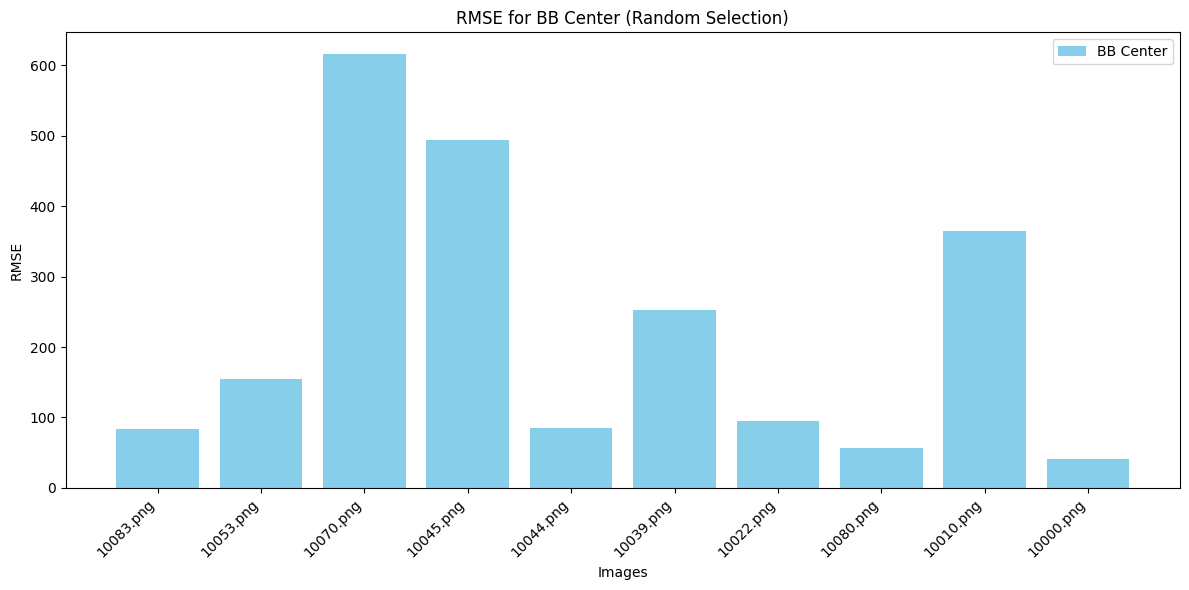

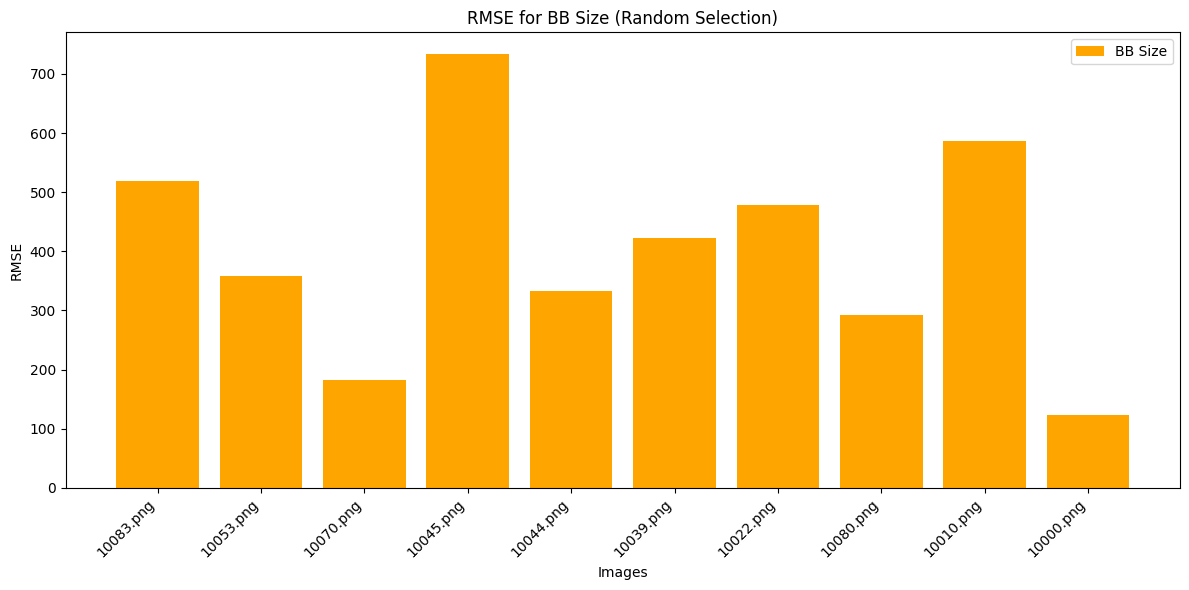

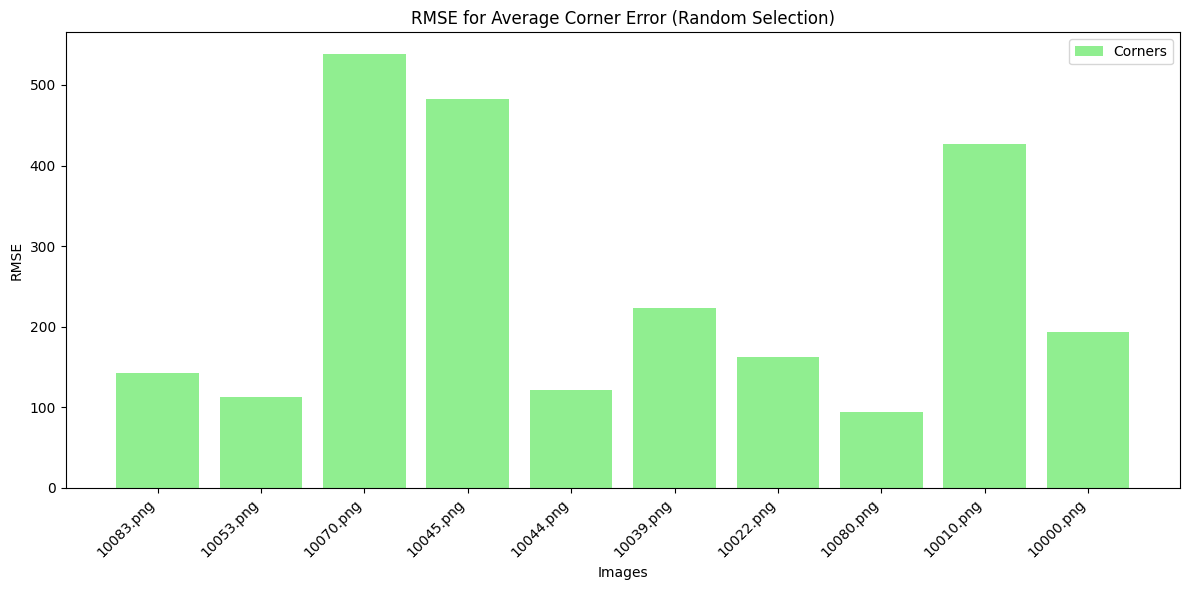

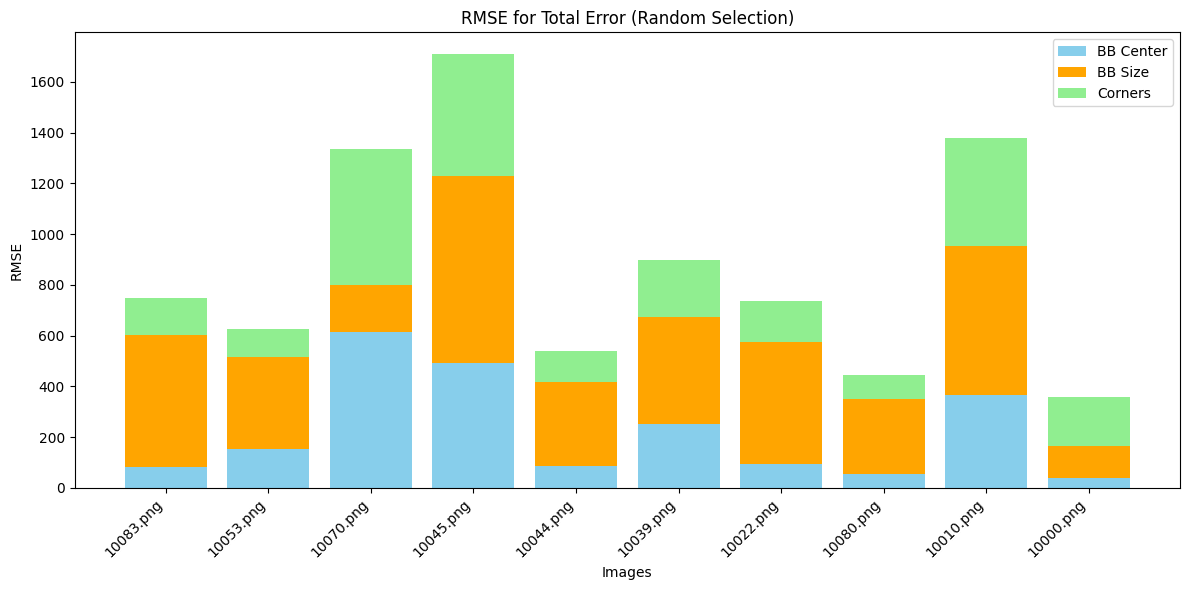

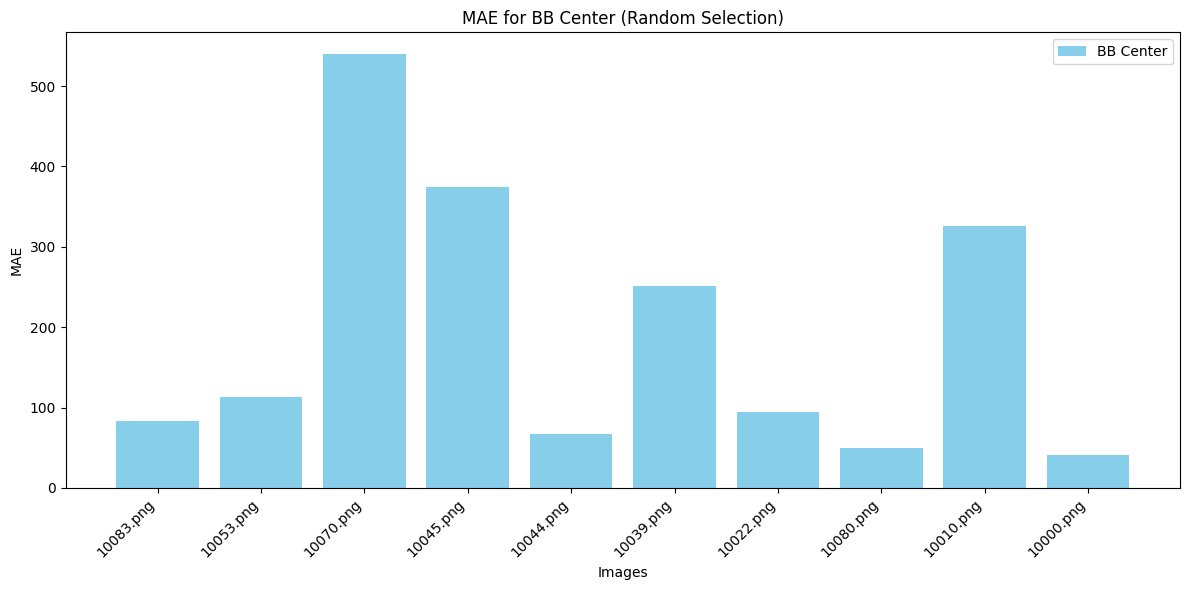

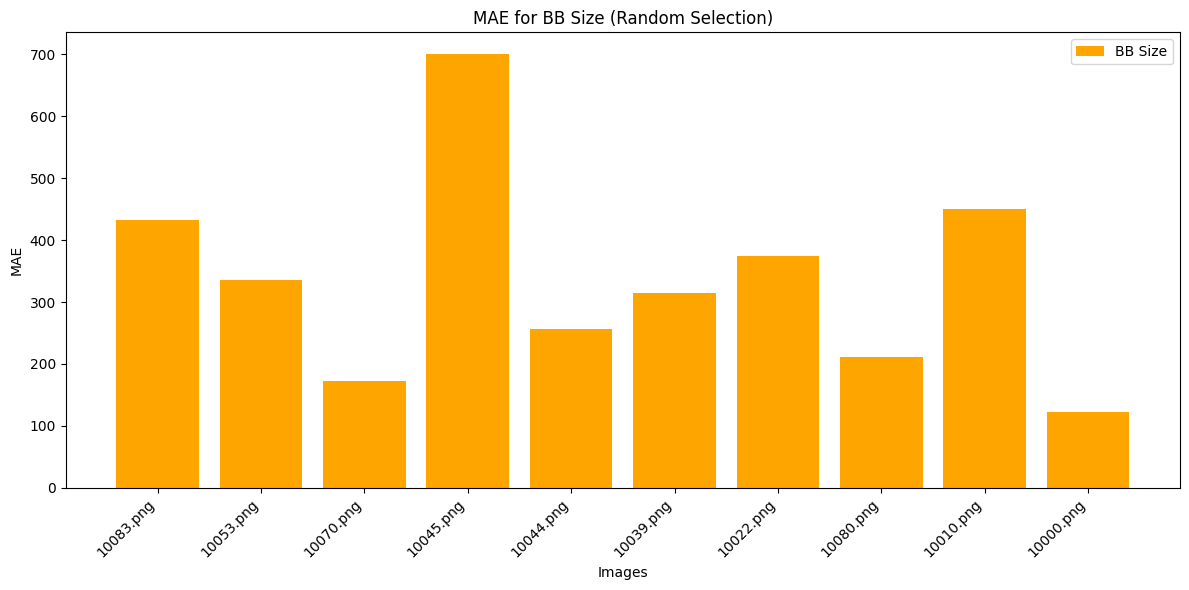

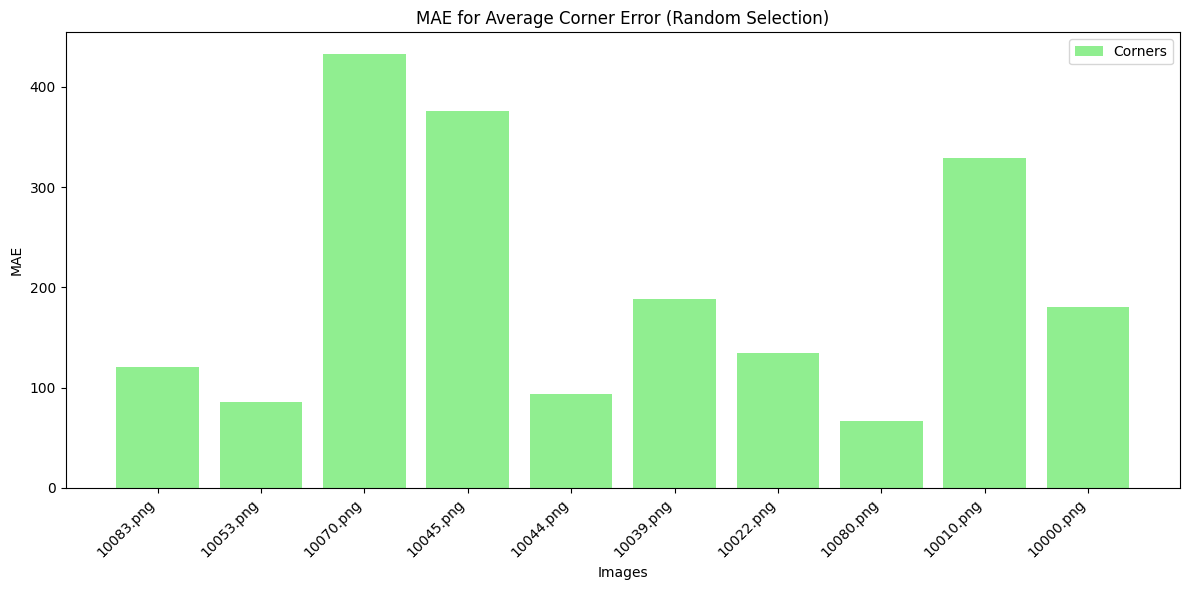

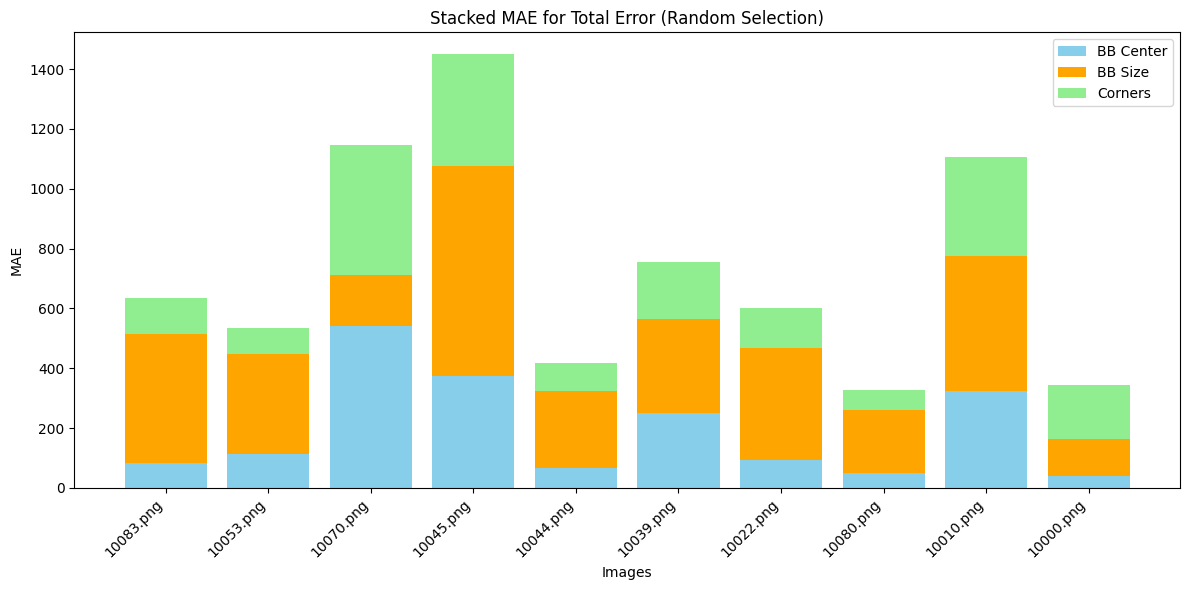

In [151]:
import random

# Function to randomly select 10 rows and visualize errors
def visualize_random_subset(errors):
    # Convert errors dictionary into DataFrame
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    # Randomly select 10 rows
    random_subset = df.sample(n=10, random_state=42)

    # Plot RMSE for BB Center
    x = np.arange(len(random_subset))
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["RMSE_BB_Center"], color="skyblue", label="BB Center")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for BB Center (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_rmse_bb_center.png", dpi=300)
    plt.show()

    # Plot RMSE for BB Size
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["RMSE_BB_Size"], color="orange", label="BB Size")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for BB Size (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_rmse_bb_size.png", dpi=300)
    plt.show()

    # Plot RMSE for Average Corner Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["RMSE_Corners"], color="lightgreen", label="Corners")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for Average Corner Error (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_rmse_corners.png", dpi=300)
    plt.show()

    # Plot Stacked RMSE for Total Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["RMSE_BB_Center"], label="BB Center", color="skyblue")
    plt.bar(x, random_subset["RMSE_BB_Size"], bottom=random_subset["RMSE_BB_Center"], label="BB Size", color="orange")
    plt.bar(x, random_subset["RMSE_Corners"], bottom=random_subset["RMSE_BB_Center"] + random_subset["RMSE_BB_Size"], label="Corners", color="lightgreen")
    plt.xlabel("Images")
    plt.ylabel("RMSE")
    plt.title("RMSE for Total Error (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_rmse_total_error.png", dpi=300)
    plt.show()

    # Plot MAE for BB Center
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["MAE_BB_Center"], color="skyblue", label="BB Center")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for BB Center (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_mae_bb_center.png", dpi=300)
    plt.show()

    # Plot MAE for BB Size
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["MAE_BB_Size"], color="orange", label="BB Size")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for BB Size (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_mae_bb_size.png", dpi=300)
    plt.show()

    # Plot MAE for Average Corner Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["MAE_Corners"], color="lightgreen", label="Corners")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("MAE for Average Corner Error (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_mae_corners.png", dpi=300)
    plt.show()

    # Plot Stacked MAE for Total Error
    plt.figure(figsize=(12, 6))
    plt.bar(x, random_subset["MAE_BB_Center"], label="BB Center", color="skyblue")
    plt.bar(x, random_subset["MAE_BB_Size"], bottom=random_subset["MAE_BB_Center"], label="BB Size", color="orange")
    plt.bar(x, random_subset["MAE_Corners"], bottom=random_subset["MAE_BB_Center"] + random_subset["MAE_BB_Size"], label="Corners", color="lightgreen")
    plt.xlabel("Images")
    plt.ylabel("MAE")
    plt.title("Stacked MAE for Total Error (Random Selection)")
    plt.xticks(x, random_subset["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_random_mae_total_error.png", dpi=300)
    plt.show()

# Call the random selection visualization
visualize_random_subset(errors)


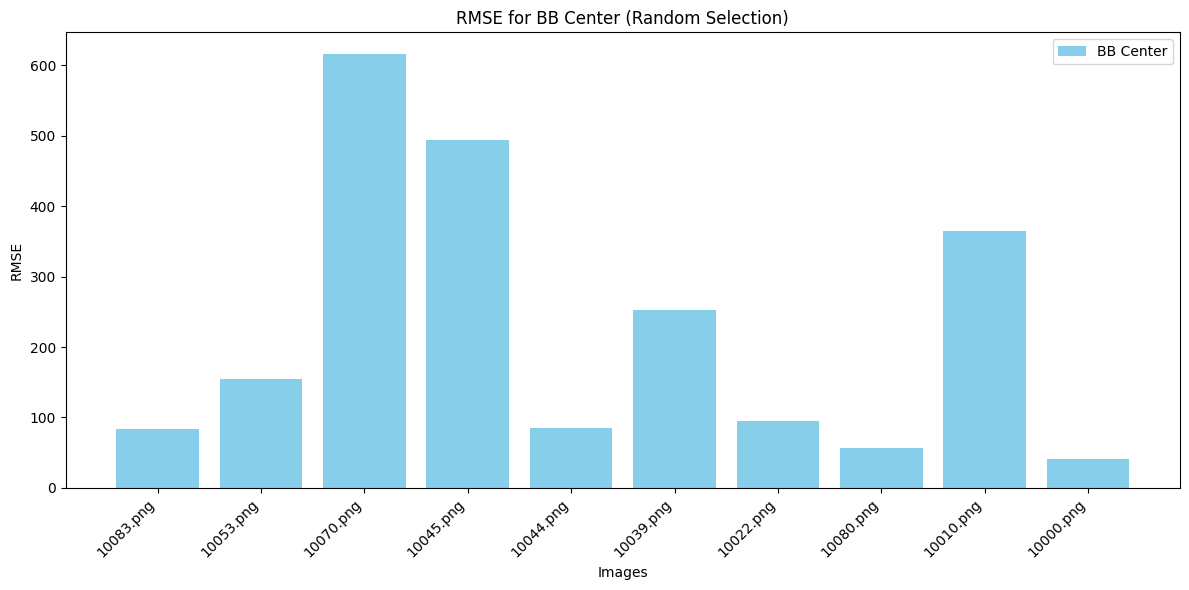

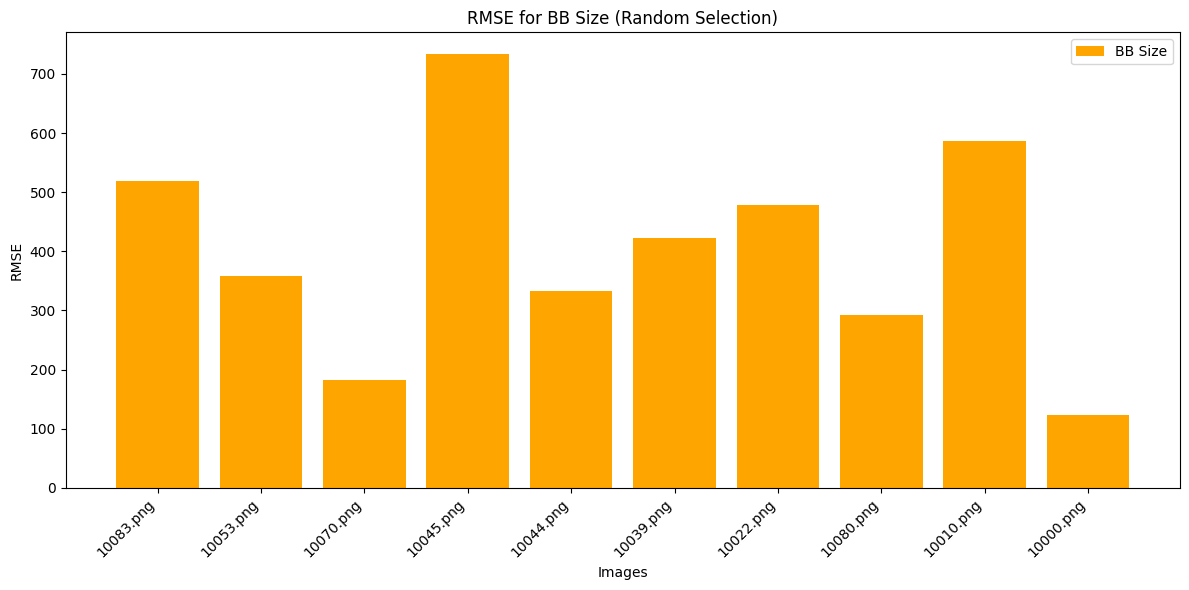

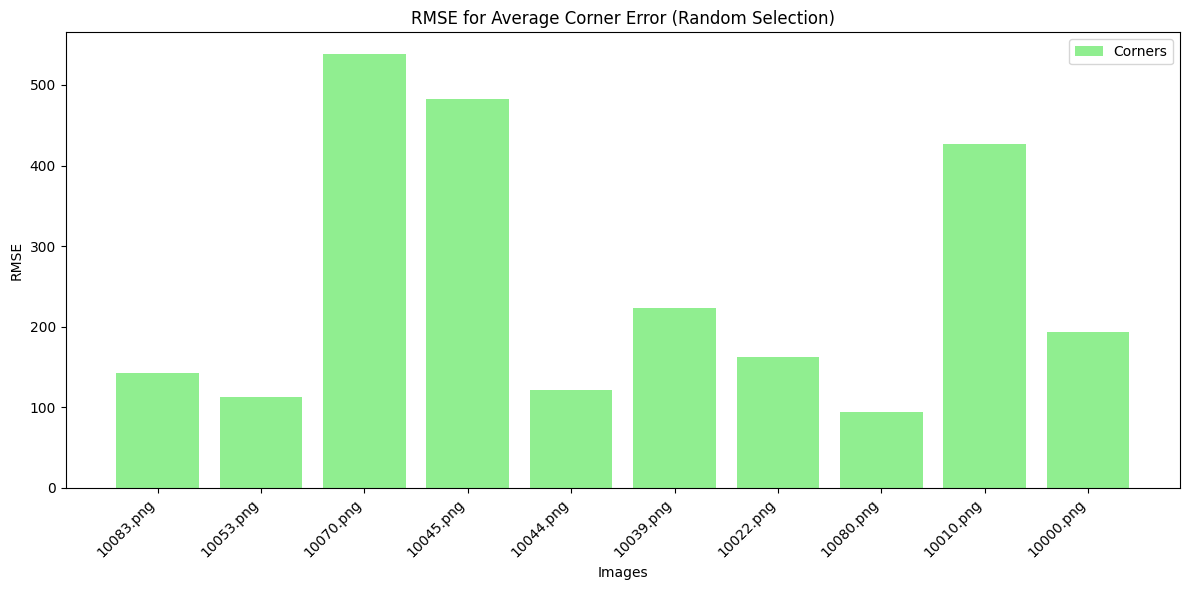

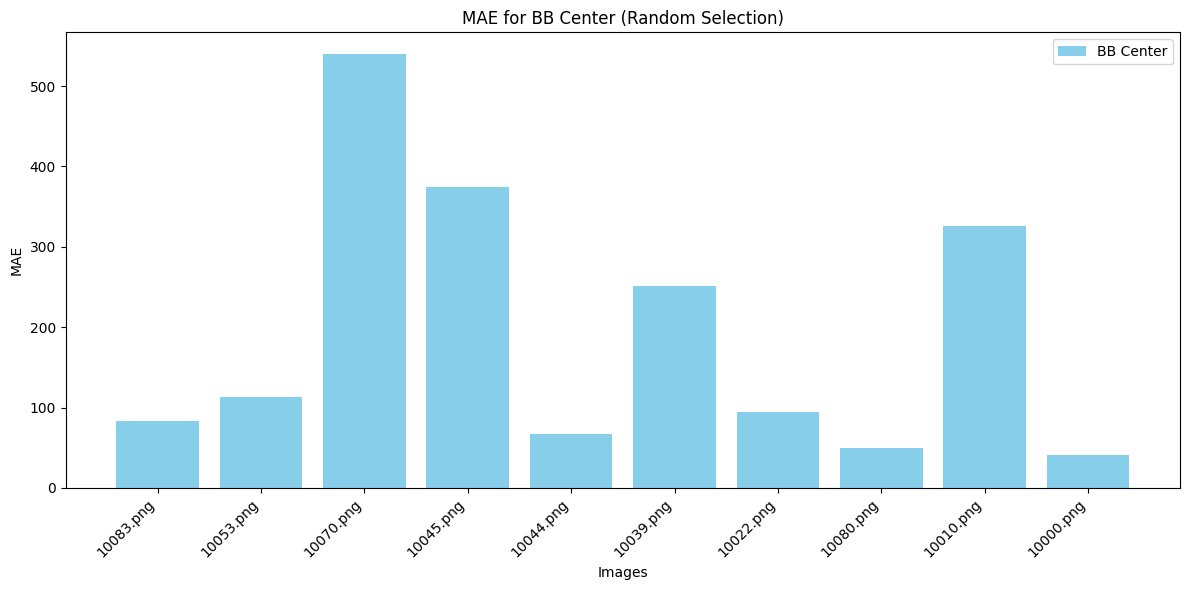

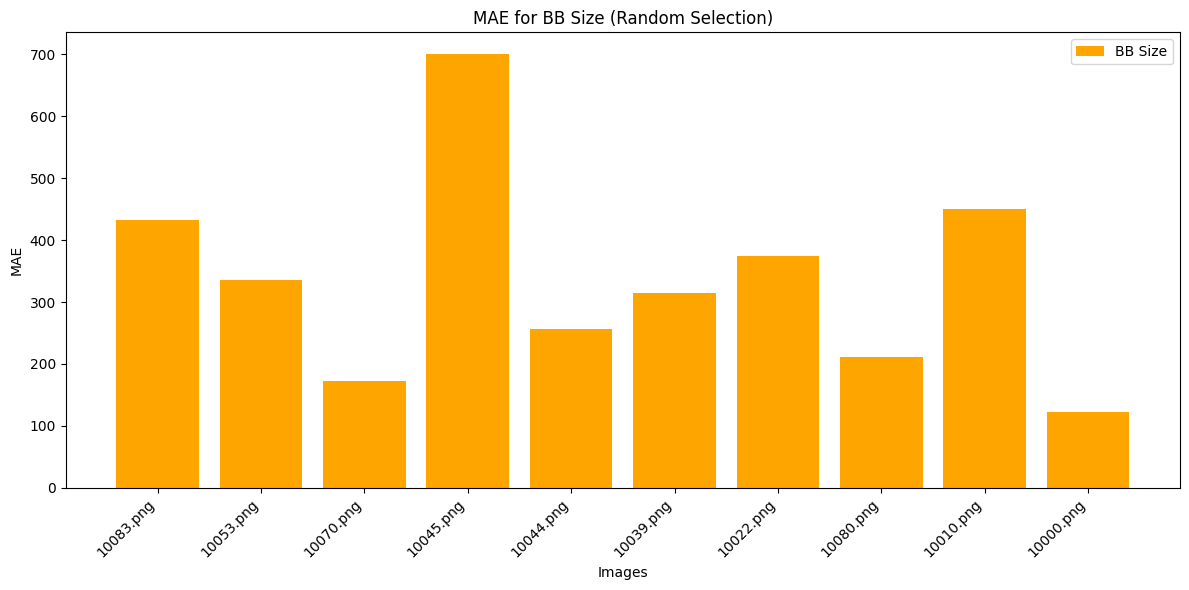

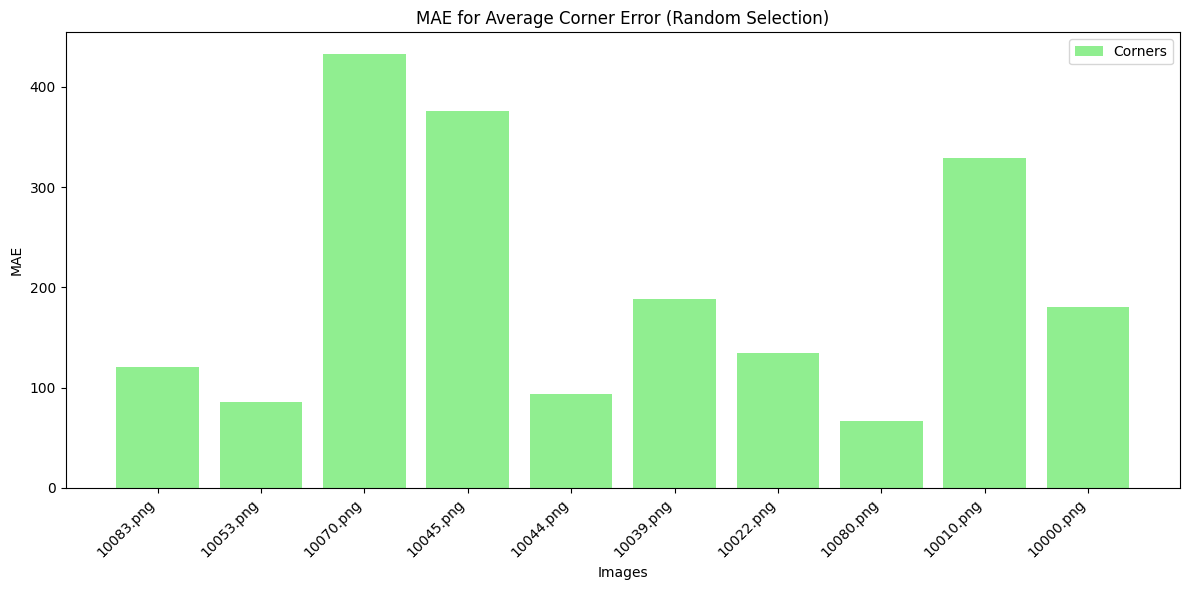

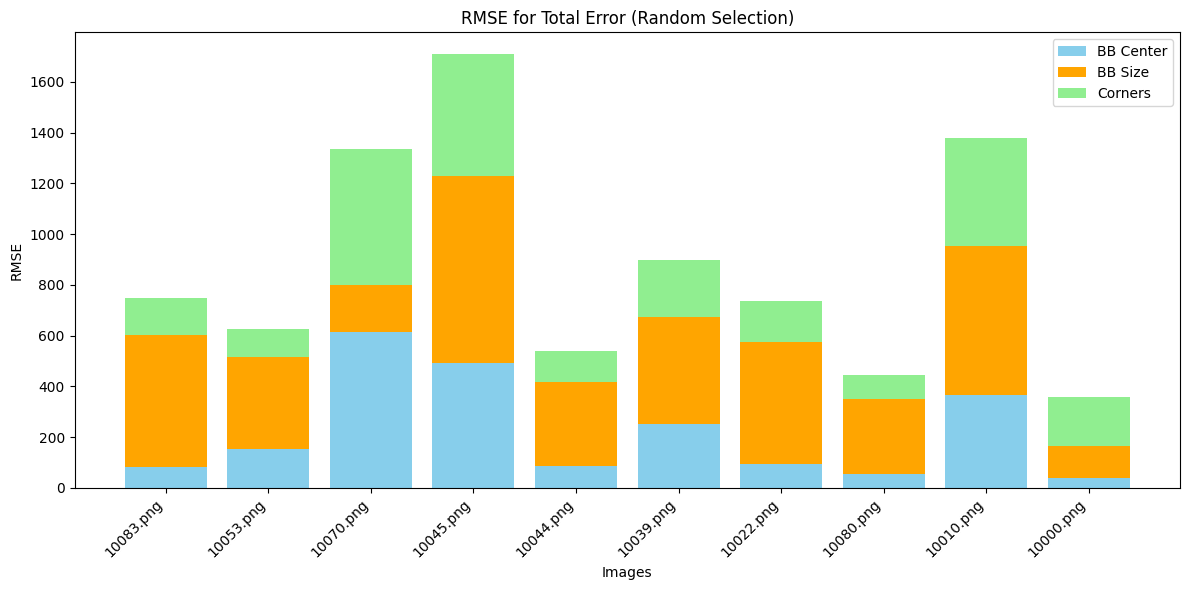

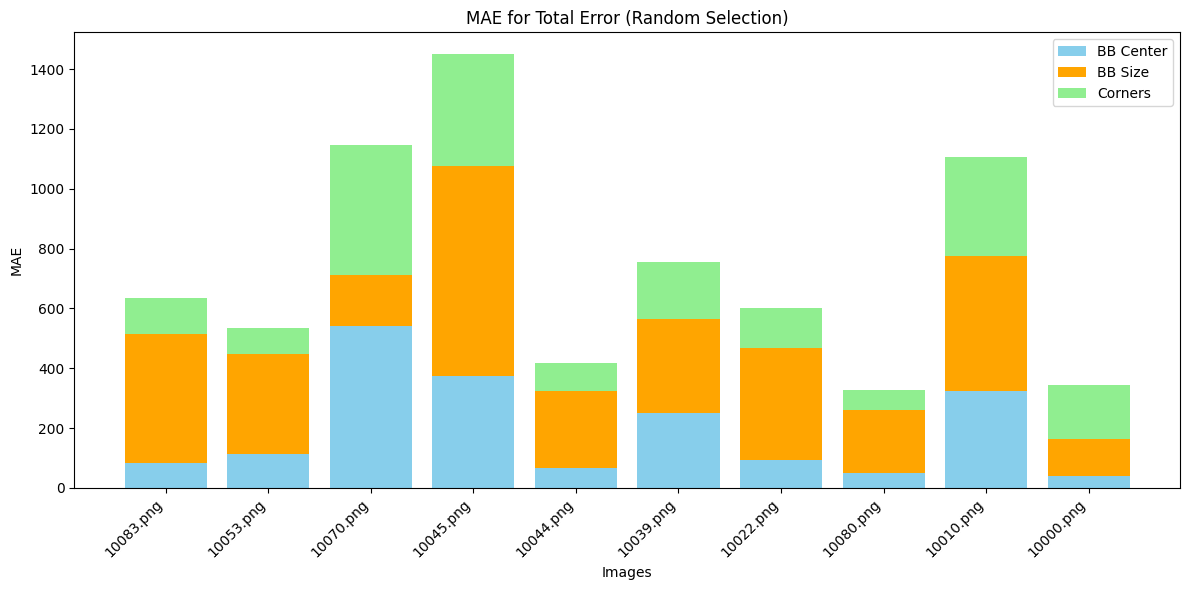

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Function to plot individual and stacked bar charts
def plot_bar_chart(df, x, columns, ylabel, title, colors, save_name, labels=None, stacked=False):
    plt.figure(figsize=(12, 6))
    if stacked:
        bottom_values = np.zeros(len(df))
        for col, color, label in zip(columns, colors, labels):
            plt.bar(x, df[col], bottom=bottom_values, color=color, label=label)
            bottom_values += df[col]
    else:
        for col, color, label in zip(columns, colors, labels):
            plt.bar(x, df[col], color=color, label=label)
    plt.xlabel("Images")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x, df["Image"], rotation=45, ha="right")
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.savefig(f"{save_dir}\\yolo_{dataset}_{save_name}.png", dpi=300)
    plt.show()

# Main visualization function for random subset
def visualize_random_subset(errors):
    # Convert errors dictionary into DataFrame
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    # Randomly select 10 rows
    random_subset = df.sample(n=10, random_state=42)
    x = np.arange(len(random_subset))

    # Define configurations for individual plots
    individual_configs = [
        {"columns": ["RMSE_BB_Center"], "ylabel": "RMSE", "title": "RMSE for BB Center (Random Selection)", "colors": ["skyblue"], "labels": ["BB Center"], "save_name": "random_rmse_bb_center"},
        {"columns": ["RMSE_BB_Size"], "ylabel": "RMSE", "title": "RMSE for BB Size (Random Selection)", "colors": ["orange"], "labels": ["BB Size"], "save_name": "random_rmse_bb_size"},
        {"columns": ["RMSE_Corners"], "ylabel": "RMSE", "title": "RMSE for Average Corner Error (Random Selection)", "colors": ["lightgreen"], "labels": ["Corners"], "save_name": "random_rmse_corners"},
        {"columns": ["MAE_BB_Center"], "ylabel": "MAE", "title": "MAE for BB Center (Random Selection)", "colors": ["skyblue"], "labels": ["BB Center"], "save_name": "random_mae_bb_center"},
        {"columns": ["MAE_BB_Size"], "ylabel": "MAE", "title": "MAE for BB Size (Random Selection)", "colors": ["orange"], "labels": ["BB Size"], "save_name": "random_mae_bb_size"},
        {"columns": ["MAE_Corners"], "ylabel": "MAE", "title": "MAE for Average Corner Error (Random Selection)", "colors": ["lightgreen"], "labels": ["Corners"], "save_name": "random_mae_corners"},
    ]


    # Plot individual bar charts
    for config in individual_configs:
        plot_bar_chart(random_subset, x, **config, stacked=False)

    # Define configurations for stacked plots
    stacked_configs = [
        {
            "columns": ["RMSE_BB_Center", "RMSE_BB_Size", "RMSE_Corners"],
            "ylabel": "RMSE",
            "title": "RMSE for Total Error (Random Selection)",
            "colors": ["skyblue", "orange", "lightgreen"],
            "labels": ["BB Center", "BB Size", "Corners"],
            "save_name": "random_rmse_total_error",
        },
        {
            "columns": ["MAE_BB_Center", "MAE_BB_Size", "MAE_Corners"],
            "ylabel": "MAE",
            "title": "MAE for Total Error (Random Selection)",
            "colors": ["skyblue", "orange", "lightgreen"],
            "labels": ["BB Center", "BB Size", "Corners"],
            "save_name": "random_mae_total_error",
        },
    ]


    # Plot stacked bar charts
    for config in stacked_configs:
        plot_bar_chart(random_subset, x, **config, stacked=True)

# Call the random selection visualization
visualize_random_subset(errors)


In [153]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import numpy as np

def draw_combined_visualization_with_black_canvas(model_path, image_path, data_2d_path):
    # Load the YOLO model and perform inference
    model = YOLO(model_path)
    results = model(image_path)[0]

    # Load the image
    img = Image.open(image_path)
    width, height = img.size
    font = ImageFont.load_default()

    # Create a black canvas
    black_canvas = Image.new("RGB", (width, height), "black")
    draw_img = ImageDraw.Draw(img)
    draw_black = ImageDraw.Draw(black_canvas)

    # --- YOLO Predictions ---
    for result in results:
        # Bounding box in xyxy format
        box = result.boxes.xyxy[0]
        x1, y1, x2, y2 = map(int, box)
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Draw YOLO bounding box in red
        for draw in [draw_img, draw_black]:
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.ellipse([center_x - 3, center_y - 3, center_x + 3, center_y + 3], fill="red", outline="red")

        # YOLO keypoints
        keypoints = result.keypoints.xy.tolist() if result.keypoints else []
        if keypoints:
            keypoints = [(int(x), int(y)) for x, y in keypoints[0] if x != 0 and y != 0]
            for i, (x, y) in enumerate(keypoints[:8]):  # Limit to 8 keypoints
                for draw in [draw_img, draw_black]:
                    draw.ellipse([x - 3, y - 3, x + 3, y + 3], fill="red", outline="red")
                    draw.text((x + 5, y + 5), str(i), fill="white", font=font)

            # Connect YOLO keypoints in orange
            top_square = keypoints[:4]
            bottom_square = keypoints[4:8]
            for i in range(4):
                for draw in [draw_img, draw_black]:
                    draw.line([top_square[i], top_square[(i + 1) % 4]], fill="orange", width=2)
                    draw.line([bottom_square[i], bottom_square[(i + 1) % 4]], fill="orange", width=2)
                    draw.line([top_square[i], bottom_square[i]], fill="orange", width=2)

    # --- 2D Data from File ---
    if os.path.exists(data_2d_path):
        df = pd.read_csv(data_2d_path, header=None)
        for _, row in df.iterrows():
            # Bounding box from 2D data
            center_x = row[1] * width
            center_y = row[2] * height
            bbox_width = row[3] * width
            bbox_height = row[4] * height

            top_left_x = center_x - (bbox_width / 2)
            top_left_y = center_y - (bbox_height / 2)
            bottom_right_x = center_x + (bbox_width / 2)
            bottom_right_y = center_y + (bbox_height / 2)

            # Draw 2D bounding box in blue
            for draw in [draw_img, draw_black]:
                draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], outline="blue", width=2)
                draw.ellipse([center_x - 3, center_y - 3, center_x + 3, center_y + 3], fill="blue", outline="blue")

            # Corner points from 2D data
            corner_points = [(row[i] * width, row[i + 1] * height) for i in range(5, 20, 2)]
            for i, (x, y) in enumerate(corner_points):
                for draw in [draw_img, draw_black]:
                    draw.ellipse([x - 3, y - 3, x + 3, y + 3], fill="blue", outline="blue")
                    draw.text((x + 5, y + 5), str(i), fill="white", font=font)

            # Connect 2D keypoints in green
            top_square = corner_points[:4]
            bottom_square = corner_points[4:]
            for i in range(4):
                for draw in [draw_img, draw_black]:
                    draw.line([top_square[i], top_square[(i + 1) % 4]], fill="green", width=2)
                    draw.line([bottom_square[i], bottom_square[(i + 1) % 4]], fill="green", width=2)
                    draw.line([top_square[i], bottom_square[i]], fill="green", width=2)
    else:
        print(f"2D data file not found at {data_2d_path}. Skipping.")

    # Save and show both images
    # img.save(output_image_path)
    # black_canvas.save(black_canvas_path)
    img.show()
    black_canvas.show()

    output_image_path = os.path.join(save_dir, f"yolo_{dataset}_combined_visualization_{file_name}.png")
    black_canvas_path = os.path.join(save_dir, f"yolo_{dataset}_combined_visualization_black_{file_name}.png")

    print(f"Annotated image saved to {output_image_path}")
    print(f"Black canvas visualization saved to {black_canvas_path}")
    
    img.save(output_image_path)
    black_canvas.save(black_canvas_path)

# Example usage
file_name = '8020'
model_path = 'C:/Users/sakar/mt-3d-environments-from-video/runs/pose/train5/weights/last.pt'
image_path = f'C:/Users/sakar/OneDrive/mt-datas/synthetic_data/12_yoro_dataset/images/val/{file_name}.png'
data_2d_path = f'C:/Users/sakar/OneDrive/mt-datas/synthetic_data/12_yoro_dataset/2d_data/{file_name}.csv'

draw_combined_visualization_with_black_canvas(model_path, image_path, data_2d_path)



image 1/1 C:\Users\sakar\OneDrive\mt-datas\synthetic_data\12_yoro_dataset\images\val\8020.png: 384x640 1 Desk, 2 Monitors, 2 Office Chairs, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Annotated image saved to C:\Users\sakar\OneDrive\mt-datas\Assets for the Report\Results Test\yolo_test_combined_visualization_8020.png
Black canvas visualization saved to C:\Users\sakar\OneDrive\mt-datas\Assets for the Report\Results Test\yolo_test_combined_visualization_black_8020.png


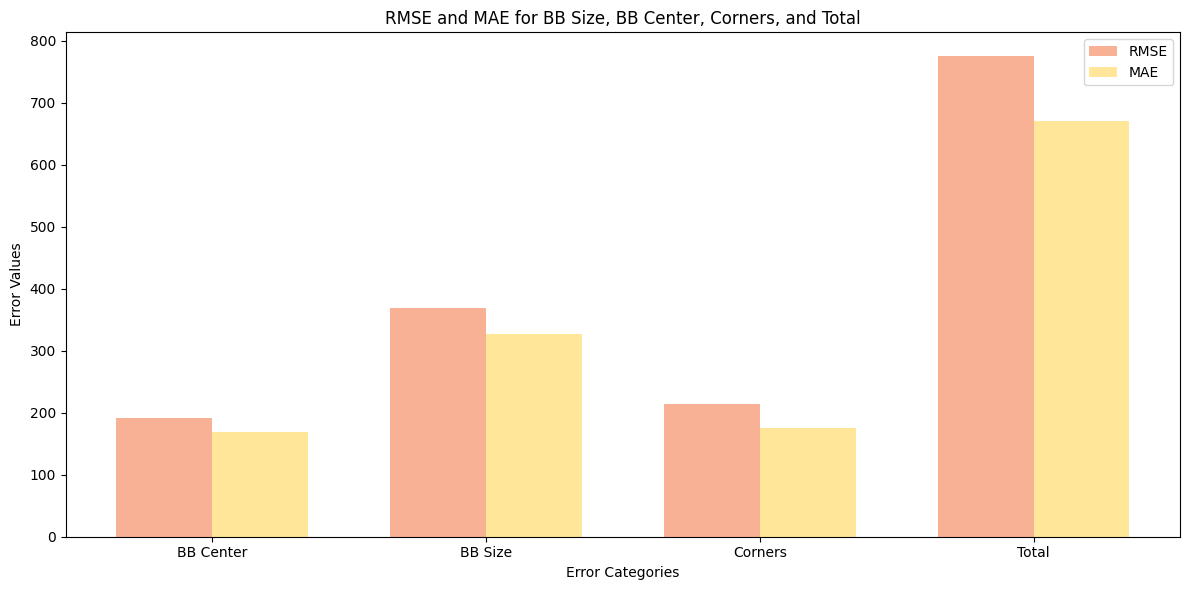

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to visualize RMSE and MAE in a single plot
def visualize_combined_errors(errors):
    # Convert errors dictionary into DataFrame
    df = pd.DataFrame.from_dict(errors, orient="index")
    df.index.name = "Image"
    df.reset_index(inplace=True)

    # Calculate the average for each metric across all images
    avg_rmse_bb_center = df["RMSE_BB_Center"].mean()
    avg_rmse_bb_size = df["RMSE_BB_Size"].mean()
    avg_rmse_corners = df["RMSE_Corners"].mean()
    avg_rmse_total = df["RMSE_Total"].mean()

    avg_mae_bb_center = df["MAE_BB_Center"].mean()
    avg_mae_bb_size = df["MAE_BB_Size"].mean()
    avg_mae_corners = df["MAE_Corners"].mean()
    avg_mae_total = df["MAE_Total"].mean()

    # Prepare data for plotting
    metrics = ["BB Center", "BB Size", "Corners", "Total"]
    rmse_values = [avg_rmse_bb_center, avg_rmse_bb_size, avg_rmse_corners, avg_rmse_total]
    mae_values = [avg_mae_bb_center, avg_mae_bb_size, avg_mae_corners, avg_mae_total]

    # Create the bar plot
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width / 2, rmse_values, width, label="RMSE", color="#F8B195")
    plt.bar(x + width / 2, mae_values, width, label="MAE", color="#FFE699")

    # Add labels, title, and legend
    plt.xlabel("Error Categories")
    plt.ylabel("Error Values")
    plt.title("RMSE and MAE for BB Size, BB Center, Corners, and Total")
    plt.xticks(x, metrics)
    plt.legend(loc="upper right")

    plt.savefig(f"{save_dir}\\yolo_{dataset}_combined_rmse_mae.png", dpi=300)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize combined errors
visualize_combined_errors(errors)


In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to visualize RMSE and MAE for a specific file
def visualize_errors_for_file(errors, file_name):
    save_dir = r"C:\Users\sakar\OneDrive\mt-datas\Assets for the Report"
    dataset = "dataset"

    if file_name not in errors:
        print(f"Error: File '{file_name}' not found in the errors dictionary.")
        return

    # Extract errors for the specified file
    file_errors = errors[file_name]

    rmse_bb_center = file_errors["RMSE_BB_Center"]
    rmse_bb_size = file_errors["RMSE_BB_Size"]
    rmse_corners = file_errors["RMSE_Corners"]
    rmse_total = file_errors["RMSE_Total"]

    mae_bb_center = file_errors["MAE_BB_Center"]
    mae_bb_size = file_errors["MAE_BB_Size"]
    mae_corners = file_errors["MAE_Corners"]
    mae_total = file_errors["MAE_Total"]

    # Prepare data for plotting
    metrics = ["BB Center", "BB Size", "Corners", "Total"]
    rmse_values = [rmse_bb_center, rmse_bb_size, rmse_corners, rmse_total]
    mae_values = [mae_bb_center, mae_bb_size, mae_corners, mae_total]

    # Create the bar plot
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    plt.figure(figsize=(12, 6))
    plt.bar(x - width / 2, rmse_values, width, label="RMSE", color="#F8B195")
    plt.bar(x + width / 2, mae_values, width, label="MAE", color="#FFE699")

    # Add labels, title, and legend
    plt.xlabel("Error Categories")
    plt.ylabel("Error Values")
    plt.title(f"RMSE and MAE for File: {file_name}")
    plt.xticks(x, metrics)
    plt.legend(loc="upper right")

    # Save the plot
    plt.savefig(f"{save_dir}\\yolo_{dataset}_errors_{file_name.replace('.png', '')}.png", dpi=300)

    # Show the plot
    plt.tight_layout()
    plt.show()

file_name = "8000.png"
visualize_errors_for_file(errors, file_name)


Error: File '8000.png' not found in the errors dictionary.
